<a href="https://colab.research.google.com/github/ElenaSaveleva/PROJECT-3.-EDA-Feature-Engineering/blob/main/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC%D0%BD%D1%8B%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## <center> *Модель прогнозирования стоимости жилья для агентства недвижимости*
---

> Провести разведывательный анализ и очистку исходных данных. Обратите
внимание, что данные в таблице реальные: в результате во многих
признаках присутствуют дублирующиеся категории, ошибки ввода,
жаргонные сокращения и т .д. Вам предстоит отыскать закономерности,
самостоятельно расшифровать все сокращения, найти синонимы в
данных, обработать пропуски и удалить выбросы.

> Задача — разработать модель, которая позволила бы агентству
недвижимости обойти конкурентов по скорости и качеству совершения
сделок.





In [3]:
!pip install category_encoders

In [4]:
# импортируем библиотеки, потребующиеся нам в дальнейшей работе
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
import category_encoders as ce
import pickle

In [5]:
# прочитаем данные
data = pd.read_csv('/content/drive/MyDrive/data/convertio.co/data.csv')

display(data.head())
print(f'{data.shape[0]} rows, {data.shape[1]} columns')

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


377185 rows, 18 columns


Описание данных:

* 'status' — статус продажи;
*'private pool' и 'PrivatePool' — наличие собственного бассейна;
* 'propertyType' — тип объекта недвижимости;
* 'street' — адрес объекта;
* 'baths' — количество ванных комнат;
* 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
* 'fireplace' — наличие камина;
* 'city' — город;
* 'schools' — сведения о школах в районе;
* 'sqft' — площадь в футах;
* 'zipcode' — почтовый индекс;
* 'beds' — количество спален;
* 'state' — штат;
* 'stories' — количество этажей;
* 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
* 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

In [6]:
# Соединяем столбцы идентификатор MLS, так как в одном из них
# может содержаться информация, отсутствующая в другом.
data['MlsId'] = data['MlsId'].fillna('') + data['mls-id'].fillna('')
data['MlsId'] = data['MlsId'].apply(lambda x: np.nan if x == '' else x)

In [7]:
#удалим столбец 'mls-id'
df = data.drop('mls-id', axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  PrivatePool   40311 non-null   object
 15  MlsId         335247 non-null  object
 16  target        374704 non-null  object
dtypes: object(17)
memory usage: 48.9+ MB


In [9]:
# Подсчет пропущенных значений для каждого столбца
missing_values = df.isnull().sum()

# Подсчет процента пропущенных значений для каждого столбца
missing_percentage = (missing_values/ len(data)) * 100

# Создание DataFrame с результатами
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Missing Percentage': missing_percentage})

# Вывод результатов
print(missing_data)

              Missing Values  Missing Percentage
status                 39918           10.583136
private pool          373004           98.891525
propertyType           34733            9.208479
street                     2            0.000530
baths                 106338           28.192532
homeFacts                  0            0.000000
fireplace             274070           72.661956
city                      34            0.009014
schools                    0            0.000000
sqft                   40577           10.757851
zipcode                    0            0.000000
beds                   91282           24.200856
state                      0            0.000000
stories               150715           39.957846
PrivatePool           336874           89.312672
MlsId                  41938           11.118682
target                  2481            0.657767


Больше всего пропусков в признаках private pool = 98% и PrivatePool = 89%. Так как эти признаки содержат одну и ту же информацию объеденим их в один признак. Так же признак fireplace сожержит 72% пропусков

In [10]:
# проверим одинаковые ли признаки
df['PrivatePool'].equals(df['private pool'])

False

In [11]:
# Проверим какие уникальные значения содержат эти признаки
df['PrivatePool'].unique()

array([nan, 'yes', 'Yes'], dtype=object)

In [12]:
df['private pool'].unique()

array([nan, 'Yes'], dtype=object)

In [13]:
# посмотрим сколько расхождений
df['PrivatePool'].isin(df['private pool']).value_counts()

True     348392
False     28793
Name: PrivatePool, dtype: int64

In [14]:
# Посмотрим на различия
# выведем только различающиеся
mask_PrivatePool = np.invert(df['PrivatePool'].isin(df['private pool']))
PrivatePool_diff = df[mask_PrivatePool][['PrivatePool','private pool']]
PrivatePool_diff

,PrivatePool,private pool
2,yes,NaN
12,yes,NaN
19,yes,NaN
43,yes,NaN
67,yes,NaN
...,...,...
377157,yes,NaN
377167,yes,NaN
377168,yes,NaN
377171,yes,NaN


In [15]:
# Проверим везде ли 'yes' в первом столбце и 'Nan' во втором
PrivatePool_diff['PrivatePool'].unique()

array(['yes'], dtype=object)

In [16]:
PrivatePool_diff['private pool'].unique()

array([nan], dtype=object)

Выявили соответствие пропущенных значений в одном признаке значению "yes" в другом признаке. Создадим новый признак Pool

In [17]:
# создам новый признак наличия бассейна
df["Pool"] = df['PrivatePool'].notnull()

In [18]:
# удалим первоначальные признаки бассейна
df.drop(['PrivatePool','private pool'], axis=1, inplace=True)

In [19]:
# проверим не появились ли дубли после этого
df.duplicated().sum()

50

# Поработаем с признаком Status

In [20]:
df['status'].describe()

count       337267
unique         159
top       for sale
freq        156104
Name: status, dtype: object

In [21]:
# Найдем дублирующиеся записи, основываясь на столбце "Status" и отфильтруем их
df[df.drop('status',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool
288267,For sale,Single Family,11207 NE 127th Ave,2.0,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,Vancouver,"[{'rating': ['4/10', '4/10', '6/10'], 'data': ...","1,670",98682,3,WA,1,19047778,"$410,000",False
17905,For sale,Single Family,11207 NE 127th Ave,2.0,"{'atAGlanceFacts': [{'factValue': '2015', 'fac...",NaN,Vancouver,"[{'rating': ['4/10', '4/10', '6/10'], 'data': ...","1,670",98682,3,WA,1,19047778,"$410,000",False
43019,for sale,lot/land,116 Country Club Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Asheville,"[{'rating': ['8/10', '5/10', '5/10', '7/10', '...",NaN,28804,NaN,NC,NaN,3462298,"$169,900",False
16290,for sale,lot/land,116 Country Club Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Asheville,"[{'rating': ['8/10', '5/10', '5/10', '7/10', '...",NaN,28804,NaN,NC,NaN,3462298,"$169,900",False
28243,for sale,lot/land,122 Sea Pines Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Winston Salem,"[{'rating': ['7/10', '7/10', '6/10'], 'data': ...",NaN,27107,NaN,NC,NaN,710159,"$58,400",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222273,for sale,single-family home,Williamsburg Plan in Creeks Crossing,2 Baths,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Lakeland,"[{'rating': ['2/10', '4/10', '2/10'], 'data': ...","2,033 sqft",33810,3 Beds,FL,1.0,NaN,"$250,900+",False
333743,for sale,lot/land,Willow St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Solon,"[{'rating': ['9/10', '9/10', '9/10', '10/10'],...",NaN,44139,NaN,OH,NaN,4099013,"$49,900",False
132967,for sale,lot/land,Willow St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Solon,"[{'rating': ['9/10', '9/10', '9/10', '10/10'],...",NaN,44139,NaN,OH,NaN,4099013,"$49,900",False
12039,for sale,lot/land,Wylie St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Houston,"[{'rating': ['3/10', '2/10', '2/10'], 'data': ...",NaN,77026,NaN,TX,NaN,10645952,"$93,500",False


In [22]:
# индексы всех дублей
index_all = df[df.drop('status',axis=1).duplicated(keep=False)].index

In [23]:
df[df.drop('status',axis=1).duplicated(keep=False)].drop('status',axis=1).drop_duplicates(keep='last')

,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool
25418,single-family home,Lexington Plan in Creeks Crossing,3 Baths,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Lakeland,"[{'rating': ['2/10', '4/10', '2/10'], 'data': ...","3,003 sqft",33810,4 Beds,FL,1.0,NaN,"$322,900+",False
28243,lot/land,122 Sea Pines Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Winston Salem,"[{'rating': ['7/10', '7/10', '6/10'], 'data': ...",NaN,27107,NaN,NC,NaN,710159,"$58,400",False
43019,lot/land,116 Country Club Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Asheville,"[{'rating': ['8/10', '5/10', '5/10', '7/10', '...",NaN,28804,NaN,NC,NaN,3462298,"$169,900",False
79257,lot/land,60TH 60th Ave S,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Saint Petersburg,"[{'rating': ['4/10', '4/10', '2/10'], 'data': ...",NaN,33712,NaN,FL,NaN,U8056924,"$99,000",False
88390,lot/land,5915 Pepper Bush Ln #L17,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Charlotte,"[{'rating': ['4/10', '6/10', '2/10'], 'data': ...",NaN,28212,NaN,NC,NaN,3570069,"$899,900",False
102797,lot/land,332 Walter Holland Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Gastonia,"[{'rating': ['4/10', '3/10', '3/10'], 'data': ...",NaN,28052,NaN,NC,NaN,60604,"$15,000",False
114960,apartment,269 W 87th St #B,6 Baths,"{'atAGlanceFacts': [{'factValue': '2018', 'fac...",NaN,New York,"[{'rating': ['8/10'], 'data': {'Distance': ['0...","3,882 sqft",10024,5 Beds,NY,NaN,1245762,"$9,500,000",False
123220,townhouse,1638 20th Ave #C,2 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Seattle,"[{'rating': ['7/10', '5/10'], 'data': {'Distan...","1,323 sqft",98122,2 Beds,WA,NaN,1477933,"$799,000",False
139942,lot/land,Pisgah View Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Asheville,"[{'rating': ['3/10'], 'data': {'Distance': ['0...",NaN,28806,NaN,NC,NaN,3488512,"$79,000",False
148558,lot/land,4606 Karen Ave N,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Lehigh Acres,"[{'rating': ['4/10', '2/10', '3/10', '2/10', '...",NaN,33971,NaN,FL,NaN,219006004,"$5,500",False


In [24]:
# индексы только более свежих записей из дублей
index_last = df[df.drop('status',axis=1).duplicated(keep=False)].drop('status',axis=1).drop_duplicates(keep='last').index

In [25]:
# теперь нужно взять разницу индексов
index_diff = np.invert(index_all.isin(index_last))

In [26]:
# применим фильтр
df_new = df.drop(index_all[index_diff])

In [27]:
df.shape[0]-df_new.shape[0]

50

# Проверим признако propertyType

In [28]:
df_new[df_new.drop('propertyType',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool
260869,for sale,lot/land,US Highway 59,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Laredo,"[{'rating': ['6/10', '4/10', '5/10'], 'data': ...",NaN,78041,NaN,TX,NaN,20193673,"$20,000",False
318227,for sale,single-family home,US Highway 59,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Laredo,"[{'rating': ['6/10', '4/10', '5/10'], 'data': ...",NaN,78041,NaN,TX,NaN,20193673,"$20,000",False


In [29]:
# индексы всех дублей
index_all2 = df_new[df_new.drop('propertyType',axis=1).duplicated(keep=False)].index

In [30]:
# индексы последних записей из дублей
index_last2 = df_new[df_new.drop('propertyType',axis=1).duplicated(keep=False)].drop('propertyType',axis=1).drop_duplicates(keep='last').index

In [31]:
# разница индексов
index_diff2 = np.invert(index_all2.isin(index_last2))

In [32]:
# применим фильтр
df_new2 = df_new.drop(index_all2[index_diff2])

In [33]:
df_new.shape[0]-df_new2.shape[0]

1

# Проверим признак baths

In [34]:
df_new2[df_new2.drop('baths',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool


Совпадений нет

# Проверим признак homeFacts

In [35]:
df_new2[df_new2.drop('homeFacts',axis=1).duplicated(keep=False)].sort_values(by='zipcode')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool
341191,for sale,lot/land,1472 Meadowlands Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Winston Salem,"[{'rating': ['7/10', '7/10', '6/10'], 'data': ...",NaN,27107,NaN,NC,NaN,709872,"$61,200",False
235171,for sale,lot/land,1472 Meadowlands Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Winston Salem,"[{'rating': ['7/10', '7/10', '6/10'], 'data': ...",NaN,27107,NaN,NC,NaN,709872,"$61,200",False
212981,for sale,multi-family,1405-1415 Woodbriar Ave #1405,NaN,"{'atAGlanceFacts': [{'factValue': '1945', 'fac...",NaN,Greensboro,"[{'rating': ['3/10', '1/10', '7/10'], 'data': ...",NaN,27405,NaN,NC,NaN,902986,"$350,000",False
245615,for sale,multi-family,1405-1415 Woodbriar Ave #1405,NaN,"{'atAGlanceFacts': [{'factValue': '1945', 'fac...",NaN,Greensboro,"[{'rating': ['3/10', '1/10', '7/10'], 'data': ...",NaN,27405,NaN,NC,NaN,902986,"$350,000",False
156054,for sale,lot/land,Camp Creek Point Dr #15,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Rosemary Beach,"[{'rating': ['7/10', '6/10', '7/10'], 'data': ...",NaN,32461,NaN,FL,NaN,805661,"$1,550,000",False
145920,for sale,lot/land,Camp Creek Point Dr #15,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Rosemary Beach,"[{'rating': ['7/10', '6/10', '7/10'], 'data': ...",NaN,32461,NaN,FL,NaN,805661,"$1,550,000",False
170417,for sale,lot/land,Starry St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Orlando,"[{'rating': ['5/10', '7/10', '7/10'], 'data': ...",NaN,32833,NaN,FL,NaN,O5808224,"$64,900",False
69768,for sale,lot/land,Starry St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Orlando,"[{'rating': ['5/10', '7/10', '7/10'], 'data': ...",NaN,32833,NaN,FL,NaN,O5808224,"$64,900",False
231449,NaN,Condo,151 SE 1st St APT 711,2.0,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...",962,33131,2,FL,NaN,A10191240,"$390,000",False
115475,NaN,Condo,151 SE 1st St APT 711,2.0,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...",962,33131,2,FL,NaN,A10191240,"$390,000",False


In [36]:
# индексы всех дублей
index_all3 = df_new2[df_new2.drop('homeFacts',axis=1).duplicated(keep=False)].index

In [37]:
# индексы только более свежих записей из дублей
index_last3 = df_new2[df_new2.drop('homeFacts',axis=1).duplicated(keep=False)].drop('homeFacts',axis=1).drop_duplicates(keep='last').index

In [38]:
# разница индексов
index_diff3 = np.invert(index_all3.isin(index_last3))

In [39]:
# применим фильтр
df_new3 = df_new2.drop(index_all3[index_diff3])

In [40]:
df_new2.shape[0]-df_new3.shape[0]

25

# Проверим признак fireplace

In [41]:
df_new3[df_new3.drop('fireplace',axis=1).duplicated(keep=False)].sort_values(by='zipcode')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool


Совпадений нет

# Проверим признак city

In [42]:
df_new3[df_new3.drop('city',axis=1).duplicated(keep=False)].sort_values(by='zipcode')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool
52249,for sale,lot/land,14520 Bill Newkirk Way,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Horizon City,"[{'rating': ['4/10', '6/10', '3/10'], 'data': ...",NaN,79928,NaN,TX,NaN,817926,"$395,000",False
253003,for sale,lot/land,14520 Bill Newkirk Way,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Horizon,"[{'rating': ['4/10', '6/10', '3/10'], 'data': ...",NaN,79928,NaN,TX,NaN,817926,"$395,000",False


In [43]:
# индексы всех дублей
index_all4 = df_new3[df_new3.drop('city',axis=1).duplicated(keep=False)].index

In [44]:
# индексы только более свежих записей из дублей
index_last4 = df_new3[df_new3.drop('city',axis=1).duplicated(keep=False)].drop('city',axis=1).drop_duplicates(keep='last').index

In [45]:
# разница индексов
index_diff4 = np.invert(index_all4.isin(index_last4))

In [46]:
# применим фильтр
df_new4 = df_new3.drop(index_all4[index_diff4])

In [47]:
df_new3.shape[0]-df_new4.shape[0]

1

# Проверим признак schools

In [48]:
df_new4[df_new4.drop('schools',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool
26352,NaN,Condo,45 SW 9th St APT 1107,1.0,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Miami,"[{'rating': ['4/10', '10/10', '2/10'], 'data':...",620,33130,1,FL,NaN,A10435204,"$365,000",False
229168,NaN,Condo,45 SW 9th St APT 1107,1.0,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Miami,"[{'rating': ['8/10', '10/10', '2/10'], 'data':...",620,33130,1,FL,NaN,A10435204,"$365,000",False
217456,for sale,single-family home,5707 W Quinault Ave,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Kennewick,"[{'rating': ['7/10', '4/10'], 'data': {'Distan...","1,173 sqft",99336,3 Beds,WA,1.0,NaN,"$125,000",False
371403,for sale,single-family home,5707 W Quinault Ave,2 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Kennewick,"[{'rating': ['7/10', '4/10'], 'data': {'Distan...","1,173 sqft",99336,3 Beds,WA,1.0,NaN,"$125,000",False
118879,for sale,townhouse,574 Boulevard Pl,3.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Atlanta,"[{'rating': ['6/10', '8/10', '3/10'], 'data': ...","2,557 sqft",30308,3 Beds,GA,NaN,NaN,"$969,900",False
82938,for sale,townhouse,574 Boulevard Pl,3.5 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Atlanta,"[{'rating': ['6/10', '8/10', '3/10'], 'data': ...","2,557 sqft",30308,3 Beds,GA,NaN,NaN,"$969,900",False
200612,for sale,lot/land,Adams Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Cincinnati,"[{'rating': ['2/10'], 'data': {'Distance': ['0...",NaN,45231,NaN,OH,NaN,1633779,"$49,900",False
267235,for sale,lot/land,Adams Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Cincinnati,"[{'rating': ['2/10'], 'data': {'Distance': ['1...",NaN,45231,NaN,OH,NaN,1633779,"$49,900",False
207900,for sale,lot/land,Clough Pike,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Cincinnati,"[{'rating': ['4/10', '7/10', '6/10'], 'data': ...",NaN,45245,NaN,OH,NaN,1616147,"$179,900",False
261918,for sale,lot/land,Clough Pike,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Cincinnati,"[{'rating': ['4/10', '5/10', '7/10'], 'data': ...",NaN,45245,NaN,OH,NaN,1616147,"$179,900",False


In [49]:
# индексы всех дублей
index_all4 = df_new4[df_new4.drop('schools',axis=1).duplicated(keep=False)].index

In [50]:
# индексы только более свежих записей из дублей
index_last4 = df_new4[df_new4.drop('schools',axis=1).duplicated(keep=False)].drop('schools',axis=1).drop_duplicates(keep='last').index

In [51]:
# разница индексов
index_diff4 = np.invert(index_all4.isin(index_last4))

In [52]:
# применим фильтр
df_new5 = df_new4.drop(index_all4[index_diff4])

In [53]:
df_new4.shape[0]-df_new5.shape[0]

11

# Проверим признак sqft

In [54]:
df_new5[df_new5.drop('sqft',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool
108922,NaN,Townhouse,Buildable plan: OAKLEY Baypointe,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Jacksonville,"[{'rating': ['4/10', '2/10', '4/10'], 'data': ...","1,500",32256,3,FL,2,NaN,"$218,990",False
168227,NaN,Townhouse,Buildable plan: OAKLEY Baypointe,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Jacksonville,"[{'rating': ['4/10', '2/10', '4/10'], 'data': ...","1,502",32256,3,FL,2,NaN,"$218,990",False


In [55]:
# индексы всех дублей
index_all5 = df_new5[df_new5.drop('sqft',axis=1).duplicated(keep=False)].index

In [56]:
# индексы только более свежих записей из дублей
index_last5 = df_new5[df_new5.drop('sqft',axis=1).duplicated(keep=False)].drop('sqft',axis=1).drop_duplicates(keep='last').index

In [57]:
# разница индексов
index_dif5 = np.invert(index_all5.isin(index_last5))

In [58]:
# применим фильтр
df_new6 = df_new5.drop(index_all5[index_dif5])

In [59]:
df_new5.shape[0]-df_new6.shape[0]

1

# проверим признак beds

In [60]:
df_new5[df_new5.drop('beds',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool
227481,Foreclosed,SingleFamilyResidence,5435 Boxwood Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Dayton,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...",NaN,45414,-- sqft,OH,NaN,NaN,NaN,False
289592,Foreclosed,SingleFamilyResidence,5435 Boxwood Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Dayton,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...",NaN,45414,"2,614 sqft",OH,NaN,NaN,NaN,False


In [61]:
# индексы всех дублей
index_all6 = df_new6[df_new6.drop('beds',axis=1).duplicated(keep=False)].index
# индексы только более свежих записей из дублей
index_last6 = df_new6[df_new6.drop('beds',axis=1).duplicated(keep=False)].drop('beds',axis=1).drop_duplicates(keep='last').index
# разница индексов
index_diff6 = np.invert(index_all6.isin(index_last6))
# применим фильтр
df_new7 = df_new6.drop(index_all6[index_diff6])

In [62]:
df_new6.shape[0]-df_new7.shape[0]

1

# проверим признак state

In [63]:
df_new7[df_new7.drop('state',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool


Совпадений нет

# проверим признак stories

In [64]:
df_new7[df_new7.drop('stories',axis=1).duplicated(keep=False)].sort_values(by='street')

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool
369460,for sale,townhouse,1107 Devereaux Ave,2 Baths,"{'atAGlanceFacts': [{'factValue': '1939', 'fac...",NaN,Philadelphia,"[{'rating': ['2/10', '1/10', '1/10'], 'data': ...","1,090 sqft",19111,3 Beds,PA,2,PAPH855150,"$175,000",False
347489,for sale,townhouse,1107 Devereaux Ave,2 Baths,"{'atAGlanceFacts': [{'factValue': '1939', 'fac...",NaN,Philadelphia,"[{'rating': ['2/10', '1/10', '1/10'], 'data': ...","1,090 sqft",19111,3 Beds,PA,2.0,PAPH855150,"$175,000",False
66441,for sale,condo,1255 N Paulina St #109,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",yes,Chicago,"[{'rating': ['1/10', '4/10', '7/10'], 'data': ...","1,890 sqft",60622,2 Beds,IL,7,10460531,"$787,500",False
195377,for sale,condo,1255 N Paulina St #109,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",yes,Chicago,"[{'rating': ['1/10', '4/10', '7/10'], 'data': ...","1,890 sqft",60622,2 Beds,IL,7.0,10460531,"$787,500",False
21095,for sale,multi-family,1270 Herkimer St,3 Baths,"{'atAGlanceFacts': [{'factValue': '1901', 'fac...",NaN,Brooklyn,"[{'rating': ['3/10', '3/10', '4/10', '1/10', '...","2,120 sqft",11233,6 Beds,NY,2,NaN,"$869,000",False
102450,for sale,multi-family,1270 Herkimer St,3 Baths,"{'atAGlanceFacts': [{'factValue': '1901', 'fac...",NaN,Brooklyn,"[{'rating': ['3/10', '3/10', '4/10', '1/10', '...","2,120 sqft",11233,6 Beds,NY,2.0,NaN,"$869,000",False
348986,foreclosure,single-family home,1328 E Mount Pleasant Ave,2 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Philadelphia,"[{'rating': ['1/10', '1/10'], 'data': {'Distan...","1,598 sqft",19150,2 Beds,PA,2,PAPH839576,"$131,000",False
76530,foreclosure,single-family home,1328 E Mount Pleasant Ave,2 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Philadelphia,"[{'rating': ['1/10', '1/10'], 'data': {'Distan...","1,598 sqft",19150,2 Beds,PA,2.0,PAPH839576,"$131,000",False
229614,for sale,single-family home,179 Pine Haven Dr,4 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",yes,Saint Johns,"[{'rating': ['9/10'], 'data': {'Distance': ['1...","3,399 sqft",32259,4 Beds,FL,2,1023872,"$538,990",False
97462,for sale,single-family home,179 Pine Haven Dr,4 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",yes,Saint Johns,"[{'rating': ['9/10'], 'data': {'Distance': ['1...","3,399 sqft",32259,4 Beds,FL,2.0,1023872,"$538,990",False


In [65]:
# индексы всех дублей
index_all7 = df_new7[df_new7.drop('stories',axis=1).duplicated(keep=False)].index
# индексы только более свежих записей из дублей
index_lsxt7 = df_new7[df_new7.drop('stories',axis=1).duplicated(keep=False)].drop('stories',axis=1).drop_duplicates(keep='last').index
# разница индексов
index_diff7 = np.invert(index_all7.isin(index_lsxt7))
# применим фильтр
df_new8 = df_new7.drop(index_all7[index_diff7])

In [66]:
df_new7.shape[0]-df_new8.shape[0]

28

In [67]:
# Указываем путь и имя файла для сохранения
file_path = '/content/drive/MyDrive/data/df_new7.csv'

# Сохраняем DataFrame в формате CSV
df_new7.to_csv(file_path, index=False)

print("Файл сохранен по пути:", file_path)

Файл сохранен по пути: /content/drive/MyDrive/data/df_new7.csv


In [68]:
# прочитаем файл
df_cleaned = pd.read_csv('/content/drive/MyDrive/data/df_new7.csv')
df_cleaned

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,611019,"$418,000",False
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,201916904,"$310,000",False
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,FR19221027,"$2,895,000",True
3,for sale,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,14191809,"$2,395,000",False
4,for sale,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,861745,"$5,000",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377090,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,A10702700,"$1,249,000",True
377091,for sale,condo,3530 N Lake Shore Dr #4B,3 Baths,"{'atAGlanceFacts': [{'factValue': '1924', 'fac...",NaN,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,10374233,"$674,999",False
377092,for sale,single-family home,15509 Linden Blvd,3 Baths,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",11434,3 Beds,NY,2,NaN,"$528,000",False
377093,NaN,NaN,7810 Pereida St,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,NaN,"$34,500",False


В признаках данного датасета имеют большое количество возможных значений. Начнем анализ с признака Status

In [69]:
# Посмотрим на строки с пропущенными значениями в этом признаке
df_cleaned[df_cleaned.status.isna()]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool
9,NaN,Single Family,8612 Cedar Plains Ln,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['4/10', '3/10', '2/10'], 'data': ...","1,930",77080,3,TX,2.0,73968331,"$311,995",False
14,NaN,Single Family,15351 Falmouth Ave,3,"{'atAGlanceFacts': [{'factValue': '1982', 'fac...",NaN,Houston,"[{'rating': ['4/10', '5/10', '7/10'], 'data': ...","2,454",77084,4,TX,2.0,65299510,"$168,800",False
33,NaN,Condo,3750 NE 170th St APT 407,2.0,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",NaN,North Miami Beach,"[{'rating': ['10/10', '6/10'], 'data': {'Dista...","1,085",33160,2,FL,0.0,A10775650,"$179,000",False
52,NaN,Condo,3131 NE 7th Ave UNIT 4801,4.0,"{'atAGlanceFacts': [{'factValue': '2018', 'fac...",NaN,Miami,"[{'rating': ['10/10', '2/10'], 'data': {'Dista...","1,873",33137,3,FL,NaN,A10600332,"$1,780,000",False
60,NaN,Single Family,4761 NW 7th Dr,2.0,"{'atAGlanceFacts': [{'factValue': '1964', 'fac...",NaN,Plantation,"[{'rating': ['3/10', '6/10', '5/10'], 'data': ...","2,088 sqft",33317,3,FL,1.0,NaN,"$333,543",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377086,NaN,Single Family,3263 Wolcott Pl,2.0,"{'atAGlanceFacts': [{'factValue': '1962', 'fac...",Yes,Orlando,"[{'rating': ['3/10', '1/10', '3/10'], 'data': ...","1,829 sqft",32805,3,FL,1,NaN,"$171,306",False
377088,NaN,Single Family,Buildable plan: The Torino (384L) Riverstone R...,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Houston,"[{'rating': ['7/10', '6/10', '5/10'], 'data': ...","1,841",77089,4,TX,1.0,NaN,"$252,990",False
377090,NaN,Single Family,20800 NE 23rd Ave,6.0,"{'atAGlanceFacts': [{'factValue': '1990', 'fac...",NaN,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,A10702700,"$1,249,000",True
377093,NaN,NaN,7810 Pereida St,NaN,"{'atAGlanceFacts': [{'factValue': None, 'factL...",NaN,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,NaN,"$34,500",False


In [70]:
# заполним пропущенные значения значением "undefined"
df_cleaned.status.fillna('undefined', inplace=True)

In [71]:
df_cleaned['status'].nunique()

160

In [72]:
# Посмотрим на уникальные значения призанка status
df_cleaned.status.sort_values(ascending=True).unique().tolist()

[' / auction',
 'A Active',
 'Accepted Offer',
 'Accepting backups',
 'Active',
 'Active - Auction',
 'Active - Contingent',
 'Active Backup',
 'Active Contingency',
 'Active Contingent',
 'Active Option',
 'Active Option Contract',
 'Active Under Contract',
 'Active With Contingencies',
 'Active With Offer',
 'Active with Contract',
 'Active/Contingent',
 'Apartment for rent',
 'Auction',
 'Auction - Active',
 'Back On Market',
 'Back on Market',
 'Backup',
 'Backup Contract',
 'C',
 'C Continue Show',
 'CT Insp - Inspection Contingency',
 'Closed',
 'Coming soon: Dec 1.',
 'Coming soon: Dec 10.',
 'Coming soon: Dec 11.',
 'Coming soon: Dec 12.',
 'Coming soon: Dec 13.',
 'Coming soon: Dec 14.',
 'Coming soon: Dec 15.',
 'Coming soon: Dec 16.',
 'Coming soon: Dec 18.',
 'Coming soon: Dec 2.',
 'Coming soon: Dec 20.',
 'Coming soon: Dec 23.',
 'Coming soon: Dec 24.',
 'Coming soon: Dec 25.',
 'Coming soon: Dec 27.',
 'Coming soon: Dec 3.',
 'Coming soon: Dec 4.',
 'Coming soon: Dec 5.'

In [73]:
# сделаем все буквы строчными так как это имеет значение, например, For sale и for sale это разные значения
df_cleaned.status = df_cleaned.status.str.lower()

In [74]:
# объеденим 'pendingwithcontingencies' и 'pendingw/cont
df_cleaned.status = df_cleaned.status.str.replace('pendingw/cont.','pendingwithcontingencies')

<ipython-input-74-3f5a2caf6c13>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_cleaned.status = df_cleaned.status.str.replace('pendingw/cont.','pendingwithcontingencies')


In [75]:
# объеденим значния a active и active
df_cleaned.status = df_cleaned.status.str.replace('a active','active')

In [76]:
# удалим лишние пробелы и запятые, чтобы значения сделать одинаковыми
df_cleaned.status = df_cleaned.status.str.replace(' ','').str.replace(',','')

In [77]:
# Объединим 'activeundercontract', 'activewithcontract'
df_cleaned.status = df_cleaned.status \
.str.replace('activeundercontract','activewithcontract')

In [78]:
# Объединим '/auction' с 'auction', а 'auction-active' с 'active-auction'
df_cleaned.status = df_cleaned.status \
.str.replace('/auction','auction') \
.str.replace('active-auction','auction-active')

In [79]:
# Объединим 'active-contingent', 'active/contingent', 'activecontingency', 'activewithcontingencies', 'activecontingent' в одно
df_cleaned.status = df_cleaned.status \
.str.replace('active-contingent','activecontingent') \
.str.replace('active/contingent','activecontingent') \
.str.replace('activecontingency','activecontingent') \
.str.replace('activewithcontingencies','activecontingent')

In [80]:
# Объединим 'undercontract' с 'uundercontract', а 'undercontractshowing' с 'undercontractshow' и 'undercontract-show'
df_cleaned.status = df_cleaned.status \
.str.replace('uundercontract','undercontract') \
.str.replace('undercontractshowing','undercontractshow') \
.str.replace('undercontract-show','undercontractshow')

In [81]:
# значения "Coming soon:..." можно упростить и не указывать конкретную дату
df_cleaned.status.str.match('^comingsoon.*').sum()

110

In [82]:
# заменим 110 значений
df_cleaned.status = df_cleaned.status.str.replace('^comingsoon.*','comingsoon', regex=True)

In [83]:
# объеденим 'recentlysold' и 'sold:...'
df_cleaned.status = df_cleaned.status.str.replace('^sold.*','recentlysold', regex=True)

In [84]:
# Посмотрим теперь на наиболее часто встречающиеся значения
df_cleaned.status.value_counts().nlargest(20)

forsale                   199491
active                    105650
undefined                  39911
foreclosure                 6768
newconstruction             5474
pending                     4807
pre-foreclosure             2119
undercontractshow           1985
pre-foreclosureauction      1560
p                           1488
auction                     1472
activewithcontract           720
undercontract                702
new                          690
contingent                   581
pricechange                  563
foreclosed                   458
forrent                      398
recentlysold                 289
undercontractbackups         252
Name: status, dtype: int64

In [85]:
# Посмотрим на наименее часто встречающиеся значения
df_cleaned.status.value_counts().nsmallest(30)

lease/purchase                     1
undercontractw/bckp                1
pendingsh                          1
undercontracttakingbackupoffers    1
contingent-saleofhome              1
pendingtakebackups                 1
contingaccptbackups                1
pendingw/escapeclause              1
contingentnoshow                   1
temporaryactive                    1
pendingbackupswanted               1
pendingw/backupwanted              1
conditionalcontract                1
pendingbringbackup                 1
contract                           1
backup                             1
pendingw/cont.                     2
pending-backupofferrequested       2
contingentforeclosure              2
ps                                 2
acceptingbackups                   2
pendingsale                        2
uccontinuetoshow                   2
contingent-financing               2
pending(donotshow)                 2
undercontract-noshow               2
pending-continuetoshow             2
r

In [86]:
df_cleaned.status.nunique()

95

# анализ признака propertyType

In [87]:
# Посмотрим на уникальные значения призанка propertyType
df_cleaned.propertyType.nunique()

1280

In [88]:
# сделаем все буквы строчными так как это имеет значение
df_cleaned.propertyType = df_cleaned.propertyType.str.lower()

In [89]:
# значения 'single-family home','single family home','single family' означают одно и тоже, объединим их
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('single-family home','single family') \
.str.replace('single family home','single family')

In [90]:
# удалим лишние пробелы и запятые, чтобы значения сделать одинаковыми
df_cleaned.propertyType = df_cleaned.propertyType.str.replace(' ','').str.replace(',','')

In [91]:
# значения 'multi-family','multifamily','multi-familyhome' означают одно и тоже, объединим их
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('multifamily','multi-family') \
.str.replace('multi-familyhome','multi-family')

In [92]:
# Посмотрим уникальные значения признака propertyType
df_cleaned.propertyType.sort_values(ascending=False).unique().tolist()

['yes',
 'warehouse',
 'walk-outranch',
 'villa',
 'victoriancraftsman',
 'victorianbilevel',
 'victorian/federal',
 'victorian',
 'urbancontemporary',
 'unknown',
 'twostorytri-level',
 'twostorysplit-level',
 'twostoryspanish/mediterranean',
 'twostorylowrise',
 'twostoryduplex',
 'twostory',
 'tuscan',
 'tudor/provincial',
 'tudor',
 'triplex',
 'trinity',
 'tri-leveltraditional',
 'tri-levelnorthwesterncontemporary',
 'tri-levelmodern',
 'tri-levelcraftsman',
 'tri-levelcontemporary',
 'tri-level',
 'transitionalwilliamsburg',
 'transitionalcolonial',
 'transitional',
 'traditionalzero-lotline',
 'traditionalwilliamsburg',
 'traditionalvictorian',
 'traditionaltransitionalwilliamsburg',
 'traditionaltransitionalcottage',
 'traditionaltransitional',
 'traditionaltexashillcountry',
 'traditionalstraightthru',
 'traditionalloftwithbedrooms',
 'traditionalfederal',
 'traditionalcottage',
 'traditionalcontemporary',
 'traditionalcondo/unit',
 'traditionalcolonialfederal',
 'traditionalc

In [93]:
# Объединим по первому слову
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^victorian.*','victorian', regex=True)

In [94]:
# Объединим 'twostorytri-level', 'twostorysplit-level', 'twostoryspanish/mediterranean', 'twostorylowrise', 'twostoryduplex', 'twostory', в одно
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('twostorytri-level','twostory') \
.str.replace('twostorysplit-level','twostory') \
.str.replace('twostoryspanish/mediterranean','twostory') \
.str.replace('twostorylowrise','twostory')\
.str.replace('twostoryduplex','twostory')

In [95]:
# Объединим 'tri-leveltraditional', 'tri-levelnorthwesterncontemporary', 'tri-levelmodern', 'tri-levelcraftsman', 'tri-levelcontemporary', 'tri-level',в одно
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('tri-leveltraditional','tri-level') \
.str.replace('tri-levelnorthwesterncontemporary','tri-level') \
.str.replace('tri-levelmodern','tri-level') \
.str.replace('tri-levelcraftsman','tri-level')\
.str.replace('tri-levelcontemporary','tri-level')

In [96]:
# Объединим 'transitionalwilliamsburg', 'transitionalcolonial', 'transitional' в одно
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('transitionalwilliamsburg','transitional') \
.str.replace('transitionalcolonial','transitional')

In [97]:
# Объединим в одну группу
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^traditional.*','traditional', regex=True)

In [98]:
# townhouse и townhome - это один и тот же тип. Объединим их тоже
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^townhome.*','townhouse', regex=True)

In [99]:
# Объединим в одну группу
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^townhouse.*','townhouse', regex=True)

In [100]:
# Объединим в одну группу 'texas hill country, traditional', 'texas hill country'
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('texas hill country, traditional','texas hill country')

In [101]:
# Объединим в одну группу 'straight thru, federal', 'straight thru, contemporary', 'straight thru',
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('straight thru, federal','straight thru') \
.str.replace('straight thru, contemporary','straight thru')

In [102]:
# Объединим в одну группу
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^split.*','split', regex=True)

In [103]:
# Объединим в одну группу
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^spanish.*','spanish', regex=True)

In [104]:
# Объединим в одну группу
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('^single wide.*','single wide', regex=True) \
.str.replace('^single-wide.*','single wide', regex=True)

In [105]:
# Объединим в одну группу
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^single detached.*','single detached', regex=True)

In [106]:
# Объединим в одну группу
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^side-by-side.*','side-by-side', regex=True)

In [107]:
# Объединим в одну группу rustic, spanish, traditional', 'rustic contemporary',  'rustic'
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('rustic, spanish, traditional','rustic', regex=True) \
.str.replace('rustic contemporary','rustic', regex=True)

In [108]:
# Объединим в одну группу 'resort property, single detached, vacation home, contemporary/modern, mediterranean',  'resort property, single detached, contemporary/modern, mid-century modern',
# 'resort property',
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('resort property, single detached, vacation home, contemporary/modern, mediterranean','resort property', regex=True) \
.str.replace('resort property, single detached, contemporary/modern, mid-century modern','resort property', regex=True)

In [109]:
# Объединим в одну группу
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^ranch.*','ranch', regex=True)

In [110]:
# Объединим в одну группу
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^raised ranch.*','raised ranch', regex=True)

In [111]:
# Объединим в одну группу
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^penthouse.*','penthouse', regex=True)

In [112]:
# Объединим в одну группу
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^patio.*','patio', regex=True)

In [113]:
# Объединим other
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^other.*','other', regex=True)

In [114]:
# Объединим one story
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^one story.*','one story', regex=True)

In [115]:
# Объединим old world
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^old world.*','old world', regex=True)

In [116]:
# Объединим multiplex
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^multiplex.*','multiplex', regex=True)

In [117]:
# Объединим multi-level
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^multi-level.*','multi-level', regex=True)

In [118]:
# Объединим multi family
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('^multi-family.*','multi family', regex=True) \
.str.replace('^multi-family home.*','multi family', regex=True)

In [119]:
# Объединим multi generational
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^multi generational.*','multi generational', regex=True)

In [120]:
# Объединим modern
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('^modernist.*','modern', regex=True) \
.str.replace('^modern.*','modern', regex=True)

In [121]:
# Объединим mobile home
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^mobile.*','mobile home', regex=True)

In [122]:
# Объединим mid-rise
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^mid-rise.*','mid-rise', regex=True)

In [123]:
# Объединим mid-century
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^mid-century.*','mid-century', regex=True)

In [124]:
# Объединим mfd/mobile
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('^mfd/mobile.*','mfd/mobile', regex=True) \
.str.replace('^manuf/mobile.*','mfd/mobile', regex=True)

In [125]:
# Объединим mediterranean
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^mediterranean.*','mediterranean', regex=True)

In [126]:
# Объединим manufactured
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^manufactured.*','manufactured', regex=True)

In [127]:
# Объединим low rise
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('^low-rise.*','low rise', regex=True) \
.str.replace('^low rise.*','low rise', regex=True)

In [128]:
# Объединим log
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^log.*','log', regex=True)

In [129]:
 # Объединим loft
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^loft.*','loft', regex=True)

In [130]:
# Объединим less than 4 floors
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^less than 4 floors.*','less than 4 floors', regex=True)

In [131]:
# Объединим 'lake house'
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^lake house.*','lake house', regex=True)

In [132]:
# Объединим key west
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^key west.*','key west', regex=True)

In [133]:
# Объединим houseboat
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^houseboat.*','houseboat', regex=True)

In [134]:
# Объединим high ris
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('^high-rise.*','high rise', regex=True) \
.str.replace('^high rise.*','high rise', regex=True) \
.str.replace('^hi-rise.*','high rise', regex=True)

In [135]:
# Объединим high ranch
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^hi ranch.*','high ranch', regex=True)

In [136]:
# Объединим georgian
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^georgian.*','georgian', regex=True)

In [137]:
# Объединим garden/zero lot line
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^garden/zero lot line.*','garden/zero lot line', regex=True)

In [138]:
# Объединим garden home
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^garden home.*','garden home', regex=True)

In [139]:
# Объединим french
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^french.*','french', regex=True)

In [140]:
# Объединим florida
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^florida.*','florida', regex=True)

In [141]:
# Объединим flat
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^flat.*','flat', regex=True)

In [142]:
# Объединим federal
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^federal.*','federal', regex=True)

In [143]:
# Объединим farmhouse
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^farmhouse.*','farmhouse', regex=True)

In [144]:
# Объединим farm/ranch
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^farm/ranch.*','farm/ranch', regex=True)

In [145]:
# Объединим farm house
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^farm house.*','farm house', regex=True)

In [146]:
# Объединим european
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^european.*','european', regex=True)

In [147]:
# Объединим english
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^english.*','english', regex=True)

In [148]:
# Объединим 'end unit
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^end unit.*','end unit', regex=True)

In [149]:
# Объединим elevated
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^elevated.*','elevated', regex=True)

In [150]:
# Объединим dutch
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^dutch.*','dutch', regex=True)

In [151]:
# Объединим duplex
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^duplex.*','duplex', regex=True)

In [152]:
# Объединим detached в одну
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^detached.*','detached', regex=True)

In [153]:
# Объединим designated historical home
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^designated historical home.*','designated historical home', regex=True)

In [154]:
# Объединим custom
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^custom.*','custom', regex=True)

In [155]:
# Объединим craftsman
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^craftsman.*','craftsman', regex=True)

In [156]:
# Объединим courtyard
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^courtyard.*','courtyard', regex=True)

In [157]:
# Объединим cottage
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^cottage.*','cottage', regex=True)

In [158]:
# Объединим coop
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^cooperative.*','coop', regex=True)

In [159]:
# Объединим contemporary
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^contemporary.*','contemporary', regex=True)

In [160]:
# Объединим condominium
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^condominium.*','condominium', regex=True)

In [161]:
# Объединим condo/unit
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^condo/unit.*','condo/unit', regex=True)

In [162]:
# Объединим condo/townhome, condo
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^condo/townhome.*','condo/townhome', regex=True)

In [163]:
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^condo, other.*','condo', regex=True)

In [164]:
# Объединим colonial
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^colonial.*','colonial', regex=True)

In [165]:
# Объединим coastal
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^coastal.*','coastal', regex=True)

In [166]:
# Объединим coach/carriage
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^coach/carriage.*','coach/carriage', regex=True)

In [167]:
# Объединим coop
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^co-op.*','coop', regex=True)

In [168]:
# Объединим cluster home
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^cluster home.*','cluster home', regex=True)

In [169]:
# Объединим charleston
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^charleston.*','charleston', regex=True)

In [170]:
# Объединим chalet
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^chalet.*','chalet', regex=True)

In [171]:
# Объединим carriage
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^carriage.*','carriage', regex=True)

In [172]:
# Объединим cape
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^cape.*','cape', regex=True)

In [173]:
# Объединим camp
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^camp.*','camp', regex=True)

In [174]:
# Объединим cabin
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^cabin.*','cabin', regex=True)

In [175]:
# Объединим bungalow
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^bungalow.*','bungalow', regex=True)

In [176]:
# Объединим bilevel
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('^bilevel.*','bilevel', regex=True) \
.str.replace('^bi-level.*','bilevel', regex=True)

In [177]:
# Объединим attached
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^attached.*','attached', regex=True)

In [178]:
# Объединим arts & crafts
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^arts & crafts.*','arts & crafts', regex=True)

In [179]:
# Объединим art deco
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^art deco.*','art deco', regex=True)

In [180]:
# Объединим a-frame
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^a-frame.*','a-frame', regex=True)

In [181]:
# Объединим 4plus floors
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^4\+ floors.*','4plus floors', regex=True)

In [182]:
# Объединим 3plus stories
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^3\+ stories.*','3plus stories', regex=True)

In [183]:
# Объединим 2 stories
df_cleaned.propertyType = df_cleaned.propertyType \
.str.replace('^2 stories.*','2 stories', regex=True) \
.str.replace('^2 story.*','2 stories', regex=True) \
.str.replace('^2-story.*','2 stories', regex=True)

In [184]:
# Объединим 1 story
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^1 story.*','1 story', regex=True)

In [185]:
# Объединим 1.5 story
df_cleaned.propertyType = df_cleaned.propertyType.str.replace('^1 1/2 story.*','1.5 story', regex=True)

In [186]:
# заполним unknown
df_cleaned.loc[df_cleaned.propertyType==' ','propertyType'] = 'unknown'
df_cleaned.propertyType = df_cleaned.propertyType.fillna('unknown')

In [187]:
# Посмотрим уникальные значения признака propertyType
df_cleaned['propertyType'].nunique()

540

# Поработаем с признаком baths

In [188]:
# Посмотрим уникальные значения признака baths
df_cleaned['baths'].nunique()

229

In [189]:
# Посмотрим уникальные значения признака baths
df_cleaned.baths.sort_values(ascending=True).unique().tolist()

['-- baths',
 '0',
 '0 / 0',
 '0.0',
 '0.00',
 '0.5 Baths',
 '0.75 Baths',
 '1',
 '1 / 1 / 1 / 1',
 '1 / 1-0 / 1-0 / 1-0',
 '1 ba',
 '1,000',
 '1,250',
 '1,500',
 '1,750',
 '1-0 / 1-0 / 1',
 '1-2 Baths',
 '1.0',
 '1.1 Baths',
 '1.25 Baths',
 '1.5',
 '1.5 Baths',
 '1.5 ba',
 '1.5+',
 '1.75 Baths',
 '1.75 ba',
 '1.8 Baths',
 '10',
 '10 Baths',
 '10 ba',
 '10.0',
 '10.5',
 '10.5 Baths',
 '10.5+',
 '11',
 '11 Baths',
 '11 ba',
 '11.0',
 '11.5 Baths',
 '11.5+',
 '116 / 116 / 116',
 '12',
 '12 Baths',
 '12 ba',
 '12.0',
 '12.5',
 '12.5+',
 '13',
 '13 Baths',
 '13 ba',
 '13.0',
 '14',
 '14 Baths',
 '14.0',
 '14.5+',
 '15',
 '15 Baths',
 '15.0',
 '16',
 '16 Baths',
 '16 ba',
 '16.0',
 '17',
 '17 Baths',
 '17.0',
 '18',
 '18 Baths',
 '18.0',
 '19 Baths',
 '2',
 '2 Baths',
 '2 ba',
 '2 baths',
 '2,000',
 '2,250',
 '2,500',
 '2,750',
 '2-1 / 2-1 / 1-1 / 1-1',
 '2.0',
 '2.1 Baths',
 '2.2 Baths',
 '2.25 Baths',
 '2.25 ba',
 '2.5',
 '2.5 Baths',
 '2.5 ba',
 '2.5+',
 '2.75 Baths',
 '2.8 Baths',
 '20'

In [190]:
# Удалим все буквы, поскольку нам важно только количество
df_cleaned.baths = df_cleaned.baths.str.replace('[a-zA-Z]','', regex=True)
# Удалим все пробелы
df_cleaned.baths = df_cleaned.baths.str.replace(' ','', regex=True)
# Удалим все :
df_cleaned.baths = df_cleaned.baths.str.replace(':','', regex=True)

In [191]:
df_cleaned.baths.nunique()

148

In [192]:
df_cleaned.baths = df_cleaned.baths.fillna('unknown')
df_cleaned.baths = df_cleaned.baths \
.str.replace('~','unknown', regex=True) \
.str.replace('\.\.','unknown', regex=True) \
.str.replace('--','unknown', regex=True) \
.str.replace('—','unknown', regex=True) \
.str.replace('^\s*$','unknown', regex=True) \
.str.replace('1-0/1-0/1','unknown', regex=True) \
.str.replace('116/116/116','unknown', regex=True) \
.str.replace('3-1/2-2','unknown', regex=True) \
.str.replace('1/1/1/1','unknown', regex=True) \
.str.replace('2-1/2-1/1-1/1-1','unknown', regex=True) \
.str.replace('1/1-0/1-0/1-0','unknown', regex=True) \
.str.replace('.*unknown.*','unknown', regex=True) \
.str.replace('1-2','unknown', regex=True) \
.str.replace('^0.0+','0', regex=True)

В значениях признака Baths содержатся данные (числа) целые и с точкой или запятой, возможно они означают одно и тоже. Проверим.

In [193]:
df_cleaned[df_cleaned['baths'].isin(['5.0', '5,000', '5'])].sort_values(by='street', ascending = False).head(20)

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool
223343,newconstruction,singlefamily,"Wyatt Plan, Terraza Isles",5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Miramar,"[{'rating': ['9/10', '8/10', '7/10'], 'data': ...","Total interior livable area: 4,272 sqft",33027,5 bd,FL,NaN,NaN,"$834,990",False
73710,newconstruction,singlefamily,"Westfield Plan, Spring Hill",5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spring Hill,"[{'rating': ['5/10', '6/10', '5/10'], 'data': ...","Total interior livable area: 4,075 sqft",34609,6 bd,FL,2.0,NaN,"$275,400",False
241838,undefined,singlefamily,W 23rd St,5.0,"{'atAGlanceFacts': [{'factValue': '1954', 'fac...",NaN,Miami Beach,"[{'rating': ['10/10', '4/10', '5/10'], 'data':...","4,559",33140,4,FL,NaN,A10677856,"$6,995,000",True
160600,forsale,multi family,W 134th St,5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,New York,"[{'rating': ['2/10', '1/10', '3/10'], 'data': ...","2,900 sqft",10030,4 Beds,NY,NaN,NaN,"$2,000,000",False
359021,forsale,singlefamily,Venice Plan in Sterling at West Hills,5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,West Hills,"[{'rating': ['7/10', '8/10', '7/10'], 'data': ...","3,986 sqft",91304,5 Beds,CA,2.0,NaN,"$1,050,990+",False
293213,forsale,singlefamily,Vega Elite Plan in Westcliffe at Porter Ranch ...,5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Porter Ranch,"[{'rating': ['9/10', '5/10'], 'data': {'Distan...","5,476 sqft",91326,5 Beds,CA,3.0,NaN,"$1,574,995+",False
319054,active,unknown,Undisclosed Address,"5,000","{'atAGlanceFacts': [{'factValue': '2016', 'fac...",1,Austin,"[{'rating': ['10', '8', '10', '9', '8'], 'data...","1,707",78738,Baths,TX,1,5742195,"374,900",False
170754,active,unknown,Undisclosed Address,"5,000","{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,Lakeway,"[{'rating': ['10', '10', '8'], 'data': {'Dista...","2,574",78738,Baths,TX,1,6688190,"814,000",False
76005,newconstruction,singlefamily,"Trinity Plan, Frisco Springs Riverside",5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Frisco,"[{'rating': ['7/10', '7/10', '9/10'], 'data': ...","Total interior livable area: 3,451 sqft",75033,4 bd,TX,2.0,NaN,"$489,990",False
266231,forsale,singlefamily,Trailhead Dr,5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",yes,Rosemary Beach,"[{'rating': ['7/10', '6/10', '7/10'], 'data': ...","3,525 sqft",32461,4 Beds,FL,2.0,826045,"$1,395,000",True


встречаются идентичные записи, отличающиеся только этим нюансом. Есть смысл объединить эти значения.  

In [194]:
df_cleaned.baths = df_cleaned.baths \
.str.replace('23.0','23', regex=True) \
.str.replace('44.0','44', regex=True) \
.str.replace('34.0','34', regex=True) \
.str.replace('30.0','30', regex=True) \
.str.replace('24.0','24', regex=True) \
.str.replace('22.0','22', regex=True) \
.str.replace('20.0','20', regex=True) \
.str.replace('18.0','18', regex=True) \
.str.replace('17.0','17', regex=True) \
.str.replace('16.0','16', regex=True) \
.str.replace('15.0','15', regex=True) \
.str.replace('14.0','14', regex=True) \
.str.replace('13.0','13', regex=True) \
.str.replace('12.0','12', regex=True) \
.str.replace('11.0','11', regex=True) \
.str.replace('10.0','10', regex=True) \
.str.replace('9.0','9', regex=True) \
.str.replace('8.0','8', regex=True) \
.str.replace('7.0','7', regex=True) \
.str.replace('6.0','6', regex=True) \
.str.replace('5.0','5', regex=True) \
.str.replace('4.0','4', regex=True) \
.str.replace('3.0','3', regex=True) \
.str.replace('2.0','2', regex=True) \
.str.replace('1.0','1', regex=True)

In [195]:
# Посмотрим на уникальные значения признака baths после очистки
df_cleaned.baths.sort_values(ascending=True).unique().tolist()

['0',
 '0.5',
 '0.75',
 '1',
 '1,2',
 '1,5',
 '1,7',
 '1.1',
 '1.25',
 '1.5',
 '1.5+',
 '1.75',
 '1.8',
 '10',
 '10.5',
 '10.5+',
 '100',
 '11',
 '11.5',
 '11.5+',
 '12',
 '12.5',
 '12.5+',
 '13',
 '14',
 '14.5+',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '2,2',
 '2,5',
 '2,7',
 '2.1',
 '2.2',
 '2.25',
 '2.5',
 '2.5+',
 '2.75',
 '2.8',
 '20',
 '200',
 '21',
 '22',
 '23',
 '24',
 '241',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '3,5',
 '3.1',
 '3.2',
 '3.25',
 '3.3',
 '3.5',
 '3.5+',
 '3.75',
 '30',
 '300',
 '32',
 '34',
 '35',
 '36',
 '39',
 '4',
 '4.1',
 '4.25',
 '4.5',
 '4.5+',
 '4.75',
 '40',
 '400',
 '41',
 '42',
 '43',
 '44',
 '5',
 '5.2',
 '5.25',
 '5.5',
 '5.5+',
 '500',
 '55',
 '6',
 '6.5',
 '6.5+',
 '6.75',
 '60',
 '64',
 '68',
 '7',
 '7,5+',
 '7.5',
 '7.5+',
 '76',
 '8',
 '8.5',
 '8.5+',
 '9',
 '9.5',
 '9.5+',
 'unknown']

  Проверим данные, которые вызывают сомнения - это 750 и 241

In [196]:
df_cleaned[df_cleaned['baths'].isin(['241', '750'])].sort_values(by='street', ascending = False).head(50)

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool
11112,forsale,singlefamily,1204 E Helena Ave,241,"{'atAGlanceFacts': [{'factValue': '2014', 'fac...",NaN,McAllen,"[{'rating': ['6/10', 'NA', '4/10'], 'data': {'...","Total interior livable area: 3,770 sqft",78503,4 bd,TX,1.0,NaN,"$449,000",False


Скорее всего это опечатка, так как если сопоставить площадь объекта недвижимости и количество ванных комнат, такого не может быть. Поэто заменим эти данные на количество 2 ванных комнат для 750, так как это квартиры  и для 241 укажем 4, так как это дом с большой площадью

In [197]:
df_cleaned.baths = df_cleaned.baths \
.str.replace('241','4', regex=True) \
.str.replace('750','2', regex=True)

In [198]:
df_cleaned['baths'].nunique()

107

Поработаем с признаком homeFacts

С помощью регулярных выражений получим factValue и factLabel

In [199]:
# factValue
value = df_cleaned.homeFacts.str.findall(r"\bfactValue': ([\s\S]+?), 'factLabel\b")
value

0         ['2019', '', 'Central A/C, Heat Pump', '', '',...
1         ['2019', '', '', '', '', '5828 sqft', '$159/sq...
2         ['1961', '1967', 'Forced Air', 'Central', 'Att...
3         ['2006', '2006', 'Forced Air', 'Central', 'Det...
4                 ['', '', '', '', '', '10,019 sqft', None]
                                ...                        
377090    ['1990', '1990', 'Other', 'Central', '2 spaces...
377091    ['1924', '', 'Radiant', '', 'None', '', '$337/...
377092    ['1950', '1950', 'Other', '', '2', '1,600 sqft...
377093           [None, None, None, None, None, None, None]
377094    ['2019', None, 'Electric', 'Central', 'No Data...
Name: homeFacts, Length: 377095, dtype: object

In [200]:
value[0]

["'2019'", "''", "'Central A/C, Heat Pump'", "''", "''", 'None', "'$144'"]

In [201]:
len(value[0])

7

In [202]:
value_len = pd.Series(value.apply(lambda x: len(x)))
value_len.unique()

array([7])

In [203]:
# factLabel
label = df_cleaned.homeFacts.str.findall(r"\bfactLabel': ([\s\S]+?)[}\b]")

In [204]:
label[100]

["'Year built'",
 "'Remodeled year'",
 "'Heating'",
 "'Cooling'",
 "'Parking'",
 "'lotsize'",
 "'Price/sqft'"]

In [205]:
label_len = pd.Series(label.apply(lambda x: len(x)))
label_len.unique()

array([7])

In [206]:
# создадим список названий признаков, удалив лишние кавычки
meaning_list = ','.join(label[0]).replace("'","").split(',')
meaning_list

['Year built',
 'Remodeled year',
 'Heating',
 'Cooling',
 'Parking',
 'lotsize',
 'Price/sqft']

In [207]:
# Создадим эти признаки в  фрейме
for i, val in enumerate(meaning_list):
    df_cleaned[val]=value.apply(lambda x: x[i])

In [208]:
df_cleaned.head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,...,MlsId,target,Pool,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,active,singlefamily,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,...,611019,"$418,000",False,'2019','',"'Central A/C, Heat Pump'",'','',None,'$144'
1,forsale,singlefamily,12911 E Heroy Ave,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,...,201916904,"$310,000",False,'2019','','','','','5828 sqft','$159/sqft'
2,forsale,singlefamily,2005 Westridge Rd,2,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,...,FR19221027,"$2,895,000",True,'1961','1967','Forced Air','Central','Attached Garage',"'8,626 sqft'",'$965/sqft'
3,forsale,singlefamily,4311 Livingston Ave,8,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,...,14191809,"$2,395,000",False,'2006','2006','Forced Air','Central','Detached Garage',"'8,220 sqft'",'$371/sqft'
4,forsale,lot/land,1524 Kiscoe St,unknown,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,...,861745,"$5,000",False,'','','','','',"'10,019 sqft'",None


In [209]:
# Теперь признак homeFacts можно удалить
df_cleaned = df_cleaned.drop('homeFacts', axis=1)

Поработаем с новым признаком Year built

In [210]:
df_cleaned['Year built'].value_counts()

''        58702
'2019'    32162
'2006'     8008
'2005'     7503
'2007'     7151
          ...  
'1823'        1
'1740'        1
'1700'        1
'1807'        1
'1804'        1
Name: Year built, Length: 231, dtype: int64

In [211]:
# удалим лишние кавычки
df_cleaned['Year built'] = df_cleaned['Year built'].str.replace("'",'', regex=True)

In [212]:
df_cleaned['Year built'].sort_values().unique()

array(['', '1', '1019', '1057', '1060', '1208', '1700', '1703', '1735',
       '1740', '1750', '1780', '1788', '1790', '1794', '1795', '1796',
       '1799', '1800', '1802', '1803', '1804', '1805', '1807', '1808',
       '1809', '1810', '1811', '1812', '1815', '1816', '1817', '1818',
       '1820', '1822', '1823', '1824', '1825', '1828', '1829', '1830',
       '1831', '1832', '1834', '1835', '1836', '1840', '1842', '1843',
       '1844', '1845', '1846', '1847', '1848', '1850', '1851', '1852',
       '1853', '1854', '1855', '1856', '1857', '1858', '1859', '1860',
       '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868',
       '1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876',
       '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884',
       '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892',
       '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900',
       '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908',
     

In [213]:
# Заменим пустые строки на 'None'
df_cleaned['Year built'] = df_cleaned['Year built'].str.replace('^\s*$','None', regex=True)

Заменим на 'None' значения, которые скорее всего являются ошибочными - это '1', '1208', '559990649990' и 'No Data'

In [214]:
mask_year = df_cleaned['Year built'].isin(['1','1208','559990649990','No Data'])
# заменю по маске
df_cleaned.loc[mask_year,'Year built'] = 'None'

Значения '1019', '1057', '1060' возможно являются опечаткой, поэтому заменим 0 на 9

In [215]:
# Заменим в этих трех случаях 0 на 9
df_cleaned.loc[df_cleaned['Year built']=='1019','Year built'] = '1919'
df_cleaned.loc[df_cleaned['Year built']=='1057','Year built'] = '1957'
df_cleaned.loc[df_cleaned['Year built']=='1060','Year built'] = '1960'

Поработаем с признаком Remodeled year

In [216]:
df_cleaned['Remodeled year'].value_counts()

''        199463
None       26560
'2006'      5537
'2005'      4817
'2007'      4387
           ...  
'1870'         1
'1845'         1
'1846'         1
'1869'         1
'1862'         1
Name: Remodeled year, Length: 155, dtype: int64

In [217]:
df_cleaned['Remodeled year'].sort_values().unique()

array(["''", "'0'", "'1111'", "'1738'", "'1800'", "'1845'", "'1846'",
       "'1853'", "'1862'", "'1869'", "'1870'", "'1874'", "'1876'",
       "'1877'", "'1880'", "'1883'", "'1884'", "'1885'", "'1886'",
       "'1887'", "'1888'", "'1889'", "'1890'", "'1891'", "'1892'",
       "'1893'", "'1894'", "'1895'", "'1896'", "'1897'", "'1898'",
       "'1899'", "'1900'", "'1901'", "'1902'", "'1903'", "'1904'",
       "'1905'", "'1906'", "'1907'", "'1908'", "'1909'", "'1910'",
       "'1911'", "'1912'", "'1913'", "'1914'", "'1915'", "'1916'",
       "'1917'", "'1918'", "'1919'", "'1920'", "'1921'", "'1922'",
       "'1923'", "'1924'", "'1925'", "'1926'", "'1927'", "'1928'",
       "'1929'", "'1930'", "'1931'", "'1932'", "'1933'", "'1934'",
       "'1935'", "'1936'", "'1937'", "'1938'", "'1939'", "'1940'",
       "'1941'", "'1942'", "'1943'", "'1944'", "'1945'", "'1946'",
       "'1947'", "'1948'", "'1949'", "'1950'", "'1951'", "'1952'",
       "'1953'", "'1954'", "'1955'", "'1956'", "'1957'", "'

Пропуски в этом признаке составляют:

In [218]:
df_cleaned[df_cleaned['Remodeled year'].isin(["''", "'0'", "'1111'",'None'])].shape[0]/df_cleaned.shape[0]*100

60.00981185112505

60 % пропусков в признаке - это очень иного, удалим данный признак

In [219]:
# удалим признак 'Remodeled year'
df_cleaned = df_cleaned.drop('Remodeled year', axis=1)

Поработаем с признаком 'Heating'

In [220]:
df_cleaned['Heating'].str.lower().nunique()

1919

In [221]:
# Посмотрим на уникальные значения признака baths после очистки
df_cleaned.Heating.sort_values(ascending=True).unique().tolist()

["' Apply'",
 "''",
 "', Ceiling Heating, Hot Water, Radiator'",
 "', Ductless/Mini-Split System, Gas Hot Air/Furnace'",
 "', Ductless/Mini-Split System, Heat Pump - Heat, MultiZone Heat'",
 "', Electric Baseboard Heat'",
 "', Electric Baseboard Heat, Gas Hot Air/Furnace, Natural Gas'",
 "', Electric Baseboard Heat, Heat Pump - Heat'",
 "', Electric Hot Air'",
 "', Electric Hot Air, Gas Floor Furnace, Gas Water Heater'",
 "', Electric Hot Air, Gas Floor Furnace, Heat Pump - Heat, Natural Gas'",
 "', Electric Hot Air, Gas Hot Air/Furnace'",
 "', Electric Hot Air, Gas Hot Air/Furnace, Heat Pump - Heat, MultiZone Heat, Natural Gas'",
 "', Electric Hot Air, Gas Water Heater'",
 "', Electric Hot Air, Gas Water Heater, Heat Pump - Heat'",
 "', Electric Hot Air, Gas Water Heater, Natural Gas'",
 "', Electric Hot Air, Heat Pump - Heat'",
 "', Electric Hot Air, Heat Pump - Heat, MultiZone Heat'",
 "', Electric Hot Air, Heat Pump - Heat, Natural Gas'",
 "', Electric Hot Air, Heat Pump - Heat, Pr

In [222]:
df_cleaned['Heating'].str.lower().value_counts().head(30)

'forced air'                     134304
''                               105734
'other'                           29621
'electric'                        10214
'gas'                              9293
'heat pump'                        8851
'no data'                          8608
'central air'                      7814
'central electric'                 7112
'central'                          6247
'central, electric'                4253
'baseboard'                        3814
none                               3532
'wall'                             3301
'electric heat'                    3064
'heating system'                   2709
'forced air, heat pump'            1767
'radiant'                          1485
'central air, ceiling fan(s)'      1432
'natural gas heat'                 1383
'central furnace'                  1036
'forced air, gas'                   962
'central electric, zoned'           873
'forced air heating'                810
', gas hot air/furnace'             776


In [223]:
# Посмотрим количество пропусков в признаке Heating
df_cleaned[df_cleaned['Heating'].isin(["''", "'0'", "'1111'",'None'])].shape[0]/df_cleaned.shape[0]*100

28.97572229809465

В данном признаке большое количество уникальных значений, что усложнит построение модели. Пропуски составляют29% от всех значений - это много.Поэтому принимам решение удалить этот признак.

In [224]:
# удалим признак 'Heating'
df_cleaned = df_cleaned.drop('Heating', axis=1)

Поработаем с признаком Cooling

In [225]:
df_cleaned['Cooling'].str.lower().nunique()

1439

In [226]:
df_cleaned['Cooling'].str.lower().value_counts().head(30)

'central'                                            158739
''                                                   120365
'central air'                                         14384
'no data'                                             10612
'has cooling'                                          9730
'none'                                                 7390
'central electric'                                     6154
'wall'                                                 4017
'central gas'                                          3573
none                                                   3532
'central heating'                                      2807
'cooling system'                                       2700
'central a/c'                                          2051
'other'                                                1840
'central a/c (electric), central heat (gas)'           1646
'central a/c (electric), central heat (electric)'      1429
'refrigeration'                         

In [227]:
# Посмотрим количество пропусков в признаке Cooling
df_cleaned[df_cleaned['Cooling'].isin(["''", "'0'", "'1111'",'None'])].shape[0]/df_cleaned.shape[0]*100

32.8556464551373

В данном признаке большое количество уникальных значений, что усложнит построение модели. Пропуски составляют 33% от всех значений - это много.Поэтому принимам решение удалить этот признак.

In [228]:
# удалим признак 'Cooling'
df_cleaned = df_cleaned.drop('Cooling', axis=1)

Поработаем с признаком Parking

In [229]:
df_cleaned['Parking'].str.lower().nunique()

3321

In [230]:
df_cleaned['Parking'].str.lower().value_counts().head(30)

''                                    171817
'attached garage'                      70747
'2 spaces'                             28060
'1 space'                              14250
'no data'                              13331
'detached garage'                      13200
'carport'                               7743
'off street'                            5278
'3 spaces'                              4724
none                                    3532
'carport, attached garage'              3025
'1'                                     2936
'4 spaces'                              2917
'2'                                     2753
'none'                                  2368
'on street'                             1707
'attached garage, detached garage'      1354
'0'                                     1114
'attached garage, carport'               993
'parking desc'                           900
'6 spaces'                               755
'detached garage, attached garage'       726
'driveway'

In [231]:
# Посмотрим количество пропусков в признаке Cooling
df_cleaned[df_cleaned['Parking'].isin(["''", "'0'", 'no data','none'])].shape[0]/df_cleaned.shape[0]*100

45.85873586231586

Похожая ситуация. Очень много уникальных значений и пропусков около 50%. Удаляем этот признак.

In [232]:
# удалим признак 'Parking'
df_cleaned = df_cleaned.drop('Parking', axis=1)

Поработаем с признаком lotsize

 lot size указывает на размер участка земли, на котором находится недвижимость.

In [233]:
df_cleaned['lotsize'].str.lower().nunique()

36609

In [234]:
df_cleaned['lotsize'].str.lower().value_counts().head(30)

''               33047
none             28383
'—'              25251
'no data'         5328
'-- sqft lot'     3819
'0.26 acres'      3139
'0.25 acres'      2721
'0.28 acres'      2614
'0.27 acres'      2473
'0.29 acres'      2351
'0.34 acres'      1953
'0.31 acres'      1720
'0.32 acres'      1582
'6,098 sqft'      1525
'0.3 acres'       1436
'0.33 acres'      1412
'7,405 sqft'      1357
'0.35 acres'      1356
'1 acre'          1347
'6,534 sqft'      1292
'0.46 acres'      1287
'4,356 sqft'      1270
'10,000 sqft'     1260
'0.36 acres'      1224
'5,227 sqft'      1175
'0.37 acres'      1172
'5,000 sqft'      1117
'8,712 sqft'      1030
'0.38 acres'       994
'3,920 sqft'       993
Name: lotsize, dtype: int64

In [235]:
# Посмотрим количество пропусков в признаке lotsize
df_cleaned[df_cleaned['lotsize'].isin(["''", "'—'", " ","'none'", "'no data'"])].shape[0]/df_cleaned.shape[0]*100

15.459764780758164

Снова много пропусков - 15%, удаляем признак

In [236]:
# удалим признак 'lotsize'
df_cleaned = df_cleaned.drop('lotsize', axis=1)

Поработаем с признаком Price/sqft

Данный признак напрямую зависит от целевого признака. Поэтому оставлять его нельзя, иначе будет утечка данных.

In [237]:
# удалим признак 'Price/sqft'
df_cleaned = df_cleaned.drop('Price/sqft', axis=1)

Поработаем с признаком fireplace


In [238]:
df_cleaned['fireplace'].str.lower().nunique()

1652

In [239]:
df_cleaned['fireplace'].str.lower().value_counts().head(30)

yes                          71209
1                            14544
2                             2432
not applicable                1993
fireplace                      847
3                              564
living room                    433
location                       399
wood burning                   311
gas/gas logs                   300
no                             289
fireplace yn                   287
special features               279
1 fireplace                    274
0                              271
familyrm                       246
fireplace features             239
great room                     207
wood                           206
gas logs, great room           188
ceiling fan                    186
living room, wood burning      185
4                              184
family room, wood burning      149
familyrm, gas logs             146
gas                            134
gas logs, in great room        112
gas logs                       107
gas logs, in living 

In [240]:
df_cleaned['fireplace'].isna().sum()

273983

Пропусков много больше половины, удаляем данный признак

In [241]:
# удалим признак 'fireplace'
df_cleaned = df_cleaned.drop('fireplace', axis=1)

**Посмотрим на признак city**

In [242]:
df_cleaned['city'].nunique()

2026

посмотрим есть ли различие в написании городов с заглавной буквы или прописной

In [243]:
df_cleaned['city'].str.title().nunique()

1909

Различия есть значит стоит привести к единообразию:

In [244]:
df_cleaned['city'] = df_cleaned['city'].str.title()

In [245]:
city_list = df_cleaned['city'].sort_values(ascending = False).unique().tolist()
city_list

['Zionsville',
 'Zapata',
 'Zanesville',
 'Yuba City',
 'Youngtown',
 'Youngstown',
 'York',
 'Yonkers',
 'Yeaddiss',
 'Yarrow Pt',
 'Yarrow Point',
 'Yarmouth Pt',
 'Yakima',
 'Wyoming',
 'Wylie',
 'Wrightsville Beach',
 'Worcester',
 'Wooton',
 'Woodway',
 'Woodville',
 'Woodstock',
 'Woodside',
 'Woodmere',
 'Woodland Hills',
 'Woodland',
 'Woodinville',
 'Woodhaven',
 'Woodfin',
 'Wolfforth',
 'Winterville',
 'Winters',
 'Winter Park',
 'Winter Haven',
 'Winter Garden',
 'Winston Salem',
 'Winooski',
 'Winona',
 'Winnetka',
 'Windcrest',
 'Winchester',
 'Wilton Manors',
 'Wilmington',
 'Willsboro',
 'Willow Spring',
 'Williston',
 'Williamsville',
 'Williamsport',
 'Williamsburg',
 'Wildwood',
 'Whitwell',
 'Whitsett',
 'Whitney',
 'Whitestone',
 'Whites Creek',
 'Whitefish Bay',
 'White Settlement',
 'White Plains',
 'White Oak',
 'White Cottage',
 'Wheatridge',
 'Wheaton',
 'Wheat Ridge',
 'Whallonsburg',
 'Westworth Village',
 'Westport',
 'Westover Hills',
 'Weston',
 'Westmins

Также в написании городов есть различия, помимо регистра: к названию города добавляют слова city,township, twp и т.д.

In [246]:
df_cleaned.city = df_cleaned.city \
.replace({'Allentown City':'Allentown'}) \
.replace({'Anderson Twp':'Anderson Township'}) \
.replace({'Asheville City':'Asheville'}) \
.replace({'Atlaanta':'Atlanta'}) \
.replace({'Bainbridge Is':'Bainbridge Island'}) \
.replace({'Bay Harbor Is':'Bay Harbor Islands'}) \
.replace({'Bedford Hts':'Bedford Heights'}) \
.replace({'Bee Caves':'Bee Cave'}) \
.replace({'Belllingham':'Bellingham'}) \
.replace({'Bonita Spgs':'Bonita Springs'}) \
.replace({'College Pt':'College Point'}) \
.replace({'Columbia Twp':'Columbia Township'}) \
.replace({'Commercecity':'Commerce City'}) \
.replace({'Doctor Philips':'Doctor Phillips'}) \
.replace({'Fairfield Twp.':'Fairfield Twp'}) \
.replace({'Federalheights':'Federal Heights'}) \
.replace({'Ft Lauderdale':'Fort Lauderdale'}) \
.replace({'Ft Worth':'Fort Worth'}) \
.replace({'Ft. Worth':'Fort Worth'}) \
.replace({'Herkimer Ny':'Herkimer'}) \
.replace({'Hide A Way Hills':'Hideaway Hills'}) \
.replace({'High Pt':'High Point'}) \
.replace({'Hollywood Pa':'Hollywood Park'}) \
.replace({'Jamaica Est':'Jamaica Estates'}) \
.replace({'Jc':'Johnson City'}) \
.replace({'Lakewood Twp.':'Lakewood'}) \
.replace({'Lehigh':'Lehigh Acres'}) \
.replace({'Los Feliz L':'Los Angeles'}) \
.replace({'St Albans City':'St. Albans City'}) \
.replace({'Poughkeepsie City':'Poughkeepsie'}) \
.replace({'New York City':'New York'}) \
.replace({'Nyc':'New York'}) \
.replace({'West Panama City Beach':'Panama City Beach'}) \
.replace({'P C Beach':'Panama City Beach'}) \
.replace({'West Valley':'West Valley City'}) \
.replace({'Poughkeepsie':'Poughkeepsie City'}) \
.replace({'Pittsfield Twp':'Pittsfield Township'}) \
.replace({'Piney Pt Village':'Piney Point Village'})

In [247]:
# посмотрим есть ли пропуски
df_cleaned['city'].isna().sum()

34

In [248]:
df_cleaned[df_cleaned['city'].isna()]

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool,Year built
7827,active,singlefamily,13155 W Highway 316,2,NaN,"[{'rating': ['1', '4', '3', '3', '6', '6'], 'd...",1016,32686,1,FL,2,A10445273,"$1,495,000",False,2000
21517,active,land,SE 117th Ter,unknown,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32668,NaN,FL,NaN,F10183087,"$49,900",False,None
26453,active,land,Blk 4 N America Lareedo Rd Lot 8,unknown,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,78045,NaN,TX,NaN,20183582,"$417,718",False,None
60961,active,land,Ocala,unknown,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34474,NaN,FL,NaN,F10011873,"$31,334",False,None
81477,active,land,Unditermined Unditermined,unknown,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34432,NaN,FL,NaN,A10652556,"$28,000",False,None
122293,active,land,Sw149 Ter,unknown,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34481,NaN,FL,NaN,A10697411,"$18,000",False,None
123437,active,land,26484 Deer Rd,unknown,NaN,"[{'rating': ['6', '5', '7', '7', '2', '10', 'N...",0,33955,NaN,FL,NaN,A10326590,"$4,000",False,None
130509,forsale,singlefamily,20003 Mar Rojo Y Mar Egeo,6,NaN,"[{'rating': ['5/10', 'NA', '4/10'], 'data': {'...","Total interior livable area: 5,905 sqft",20003,5 bd,MA,NaN,A10761803,"$1,650,000",False,2000
131221,active,land,19212 Roosevelt,unknown,NaN,"[{'rating': ['5', '4', '6', 'NR', '5', 'NR', '...",0,33954,NaN,FL,NaN,A10741077,"$4,200",False,None
151903,active,land,Ocala,unknown,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34474,NaN,FL,NaN,F10011860,"$31,334",False,None


In [249]:
df_cleaned.loc[df_cleaned['city'].isna(),'city'] = 'Other'

In [250]:
df_cleaned[df_cleaned['city']=='Other']

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool,Year built
7827,active,singlefamily,13155 W Highway 316,2,Other,"[{'rating': ['1', '4', '3', '3', '6', '6'], 'd...",1016,32686,1,FL,2,A10445273,"$1,495,000",False,2000
20079,active,unknown,7607 Triple Acres,unknown,Other,"[{'rating': ['2', '2', '3'], 'data': {'Distanc...","1,348",78263,NaN,TX,1,9143251,"249,000",False,1982
21517,active,land,SE 117th Ter,unknown,Other,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32668,NaN,FL,NaN,F10183087,"$49,900",False,None
26453,active,land,Blk 4 N America Lareedo Rd Lot 8,unknown,Other,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,78045,NaN,TX,NaN,20183582,"$417,718",False,None
59730,active,unknown,12604 Horseshoe Bay,unknown,Other,"[{'rating': ['8', '8', '7', '7'], 'data': {'Di...","2,310",78253,NaN,TX,1,7666481,"399,000",False,2018
60961,active,land,Ocala,unknown,Other,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34474,NaN,FL,NaN,F10011873,"$31,334",False,None
78803,active,unknown,34 Trophy Rdg,"3,5",Other,"[{'rating': ['9', '10', '8'], 'data': {'Distan...","6,300",78258,Baths,TX,2,5771544,"1,695,000",False,2016
81477,active,land,Unditermined Unditermined,unknown,Other,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34432,NaN,FL,NaN,A10652556,"$28,000",False,None
101071,active,unknown,2403 Ruth St,"1,2",Other,"[{'rating': ['4', '1', '1'], 'data': {'Distanc...",NaN,77004,Baths,TX,NaN,1116764,"250,000",False,None
107364,active,unknown,8115 Ventura Blvd,"2,5",Other,"[{'rating': ['7', '6', '6', 'NR'], 'data': {'D...","2,599",78154,Baths,TX,1,9513356,"354,000",False,2019


Поработаем с признаком schools

In [251]:
# посмотрим структуру
df_cleaned.schools[5]

"[{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}]"

In [252]:
df_cleaned.schools[50]

"[{'rating': ['4/10', '5/10', '4/10'], 'data': {'Distance': ['5.92mi', '4.01mi', '7.58mi'], 'Grades': ['PK-6', '9-12', '7-8']}, 'name': ['Bunnell Elementary School', 'Flagler-Palm Coast High School', 'Buddy Taylor Middle School']}]"

In [253]:
# rating
s_rating = df_cleaned.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b")
s_rating

0         [['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']]
1                         [['4/10', 'None/10', '4/10']]
2                            [['8/10', '4/10', '8/10']]
3                   [['9/10', '9/10', '10/10', '9/10']]
4                            [['4/10', '5/10', '5/10']]
                              ...                      
377090                              [['10/10', '5/10']]
377091                       [['1/10', '5/10', '7/10']]
377092                               [['5/10', '4/10']]
377093                             [['NA', 'NA', 'NA']]
377094                       [['5/10', '4/10', '3/10']]
Name: schools, Length: 377095, dtype: object

In [254]:
# Distance
s_distance = df_cleaned.schools.str.findall(r"\bDistance': ([\s\S]+?), 'Grades\b")
s_distance

0         [['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10....
1                          [['1.65mi', '1.32mi', '1.01mi']]
2                          [['1.19mi', '2.06mi', '2.63mi']]
3                 [['1.05mi', '0.1mi', '1.05mi', '0.81mi']]
4                          [['5.96mi', '3.25mi', '3.03mi']]
                                ...                        
377090                              [['32.1 mi', '1.1 mi']]
377091                     [['10.61mi', '1.42mi', '0.4mi']]
377092                               [['0.48mi', '0.73mi']]
377093                     [['1.3 mi', '0.5 mi', '1.9 mi']]
377094                     [['0.3 mi', '1.1 mi', '4.1 mi']]
Name: schools, Length: 377095, dtype: object

In [255]:
# Grades
s_grades = df_cleaned.schools.str.findall(r"\bGrades': ([\s\S]+?)}, 'name\b")
s_grades

0         [['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12',...
1                                 [['9-12', '3-8', 'PK-8']]
2                                  [['6-8', 'K-5', '9-12']]
3                          [['5-6', 'PK-4', '7-8', '9-12']]
4                                 [['7-8', '9-12', 'PK-6']]
                                ...                        
377090                                   [['PK-8', '9-12']]
377091                           [['9-12', '9-12', 'PK-8']]
377092                                    [['PK-5', '6-8']]
377093                            [['PK-5', '6-8', '9-12']]
377094                            [['PK-5', '6-8', '9-12']]
Name: schools, Length: 377095, dtype: object

In [256]:
# name
s_name = df_cleaned.schools.str.findall(r"\bname': ([\s\S]+?)[}\b]")
s_name

0         [['Southern Pines Elementary School', 'Souther...
1         [['East Valley High School&Extension', 'Eastva...
2         [['Paul Revere Middle School', 'Brentwood Scie...
3         [['Mcculloch Intermediate School', 'Bradfield ...
4         [['Southwest Middle School', 'Bayside High Sch...
                                ...                        
377090    [['Air Base Elementary School', 'Dr Michael M....
377091    [['Hope College Prep High School', 'Lake View ...
377092    [['Ps 48 William Wordsworth', 'Jhs 8 Richard S...
377093    [['Hiliard El', 'Forest Brook Middle', 'North ...
377094    [['Mary Lou Hartman', 'Woodlake Hills Middle S...
Name: schools, Length: 377095, dtype: object

In [257]:
s_rating

0         [['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']]
1                         [['4/10', 'None/10', '4/10']]
2                            [['8/10', '4/10', '8/10']]
3                   [['9/10', '9/10', '10/10', '9/10']]
4                            [['4/10', '5/10', '5/10']]
                              ...                      
377090                              [['10/10', '5/10']]
377091                       [['1/10', '5/10', '7/10']]
377092                               [['5/10', '4/10']]
377093                             [['NA', 'NA', 'NA']]
377094                       [['5/10', '4/10', '3/10']]
Name: schools, Length: 377095, dtype: object

In [258]:
s_rating = s_rating.apply(lambda x: x[0])
s_rating

0         ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']
1                         ['4/10', 'None/10', '4/10']
2                            ['8/10', '4/10', '8/10']
3                   ['9/10', '9/10', '10/10', '9/10']
4                            ['4/10', '5/10', '5/10']
                             ...                     
377090                              ['10/10', '5/10']
377091                       ['1/10', '5/10', '7/10']
377092                               ['5/10', '4/10']
377093                             ['NA', 'NA', 'NA']
377094                       ['5/10', '4/10', '3/10']
Name: schools, Length: 377095, dtype: object

In [259]:
s_rating = s_rating.str.replace('/10','', regex=False)
s_rating

0         ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR']
1                                  ['4', 'None', '4']
2                                     ['8', '4', '8']
3                               ['9', '9', '10', '9']
4                                     ['4', '5', '5']
                             ...                     
377090                                    ['10', '5']
377091                                ['1', '5', '7']
377092                                     ['5', '4']
377093                             ['NA', 'NA', 'NA']
377094                                ['5', '4', '3']
Name: schools, Length: 377095, dtype: object

In [260]:
s_rating = s_rating.str.replace('[a-zA-Z]','', regex=True)

In [261]:
s_rating = s_rating.str.findall(r'\b([0-9])\'')
s_rating

0         [4, 4, 7, 4, 7]
1                  [4, 4]
2               [8, 4, 8]
3               [9, 9, 9]
4               [4, 5, 5]
               ...       
377090                [5]
377091          [1, 5, 7]
377092             [5, 4]
377093                 []
377094          [5, 4, 3]
Name: schools, Length: 377095, dtype: object

In [262]:
s_rating = s_rating.apply(lambda x: [float(i) for i in x])
s_rating

0         [4.0, 4.0, 7.0, 4.0, 7.0]
1                        [4.0, 4.0]
2                   [8.0, 4.0, 8.0]
3                   [9.0, 9.0, 9.0]
4                   [4.0, 5.0, 5.0]
                    ...            
377090                        [5.0]
377091              [1.0, 5.0, 7.0]
377092                   [5.0, 4.0]
377093                           []
377094              [5.0, 4.0, 3.0]
Name: schools, Length: 377095, dtype: object

In [263]:
s_rating = s_rating.apply(lambda x: np.average([int(i) for i in x]))
s_rating

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)


0         5.200000
1         4.000000
2         6.666667
3         9.000000
4         4.666667
            ...   
377090    5.000000
377091    4.333333
377092    4.500000
377093         NaN
377094    4.000000
Name: schools, Length: 377095, dtype: float64

In [264]:
s_rating.fillna(-1)

0         5.200000
1         4.000000
2         6.666667
3         9.000000
4         4.666667
            ...   
377090    5.000000
377091    4.333333
377092    4.500000
377093   -1.000000
377094    4.000000
Name: schools, Length: 377095, dtype: float64

In [265]:
# Создадим признак rating_mean Пропуски заполним -1
df_cleaned['r_sch_mean']= s_rating.fillna(-1).round(1)

In [266]:
df_cleaned.tail()

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool,Year built,r_sch_mean
377090,undefined,singlefamily,20800 NE 23rd Ave,6,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...","4,017",33180,5,FL,0.0,A10702700,"$1,249,000",True,1990,5.0
377091,forsale,condo,3530 N Lake Shore Dr #4B,3,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","2,000 sqft",60657,3 Beds,IL,9.0,10374233,"$674,999",False,1924,4.3
377092,forsale,singlefamily,15509 Linden Blvd,3,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","1,152 sqft",11434,3 Beds,NY,2,NaN,"$528,000",False,1950,4.5
377093,undefined,unknown,7810 Pereida St,unknown,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",NaN,77028,"8,479 sqft",TX,NaN,NaN,"$34,500",False,None,-1.0
377094,undefined,singlefamily,5983 Midcrown Dr,2,San Antonio,"[{'rating': ['5/10', '4/10', '3/10'], 'data': ...","1,462",78218,3,TX,1.0,1403619,"$204,900",False,2019,4.0


Теперь признак Distance

In [267]:
s_distance

0         [['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10....
1                          [['1.65mi', '1.32mi', '1.01mi']]
2                          [['1.19mi', '2.06mi', '2.63mi']]
3                 [['1.05mi', '0.1mi', '1.05mi', '0.81mi']]
4                          [['5.96mi', '3.25mi', '3.03mi']]
                                ...                        
377090                              [['32.1 mi', '1.1 mi']]
377091                     [['10.61mi', '1.42mi', '0.4mi']]
377092                               [['0.48mi', '0.73mi']]
377093                     [['1.3 mi', '0.5 mi', '1.9 mi']]
377094                     [['0.3 mi', '1.1 mi', '4.1 mi']]
Name: schools, Length: 377095, dtype: object

In [268]:
s_distance = s_distance.apply(lambda x: x[0])
s_distance

0         ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5...
1                            ['1.65mi', '1.32mi', '1.01mi']
2                            ['1.19mi', '2.06mi', '2.63mi']
3                   ['1.05mi', '0.1mi', '1.05mi', '0.81mi']
4                            ['5.96mi', '3.25mi', '3.03mi']
                                ...                        
377090                                ['32.1 mi', '1.1 mi']
377091                       ['10.61mi', '1.42mi', '0.4mi']
377092                                 ['0.48mi', '0.73mi']
377093                       ['1.3 mi', '0.5 mi', '1.9 mi']
377094                       ['0.3 mi', '1.1 mi', '4.1 mi']
Name: schools, Length: 377095, dtype: object

In [269]:
s_distance = s_distance.str.replace('[a-zA-Z]','', regex=True)
s_distance

0         ['2.7 ', '3.6 ', '5.1 ', '4.0 ', '10.5 ', '12....
1                                  ['1.65', '1.32', '1.01']
2                                  ['1.19', '2.06', '2.63']
3                           ['1.05', '0.1', '1.05', '0.81']
4                                  ['5.96', '3.25', '3.03']
                                ...                        
377090                                    ['32.1 ', '1.1 ']
377091                             ['10.61', '1.42', '0.4']
377092                                     ['0.48', '0.73']
377093                             ['1.3 ', '0.5 ', '1.9 ']
377094                             ['0.3 ', '1.1 ', '4.1 ']
Name: schools, Length: 377095, dtype: object

In [270]:
s_distance = s_distance.str.findall(r'\b([0-9]+.[0-9]+)')
s_distance

0         [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]
1                                 [1.65, 1.32, 1.01]
2                                 [1.19, 2.06, 2.63]
3                            [1.05, 0.1, 1.05, 0.81]
4                                 [5.96, 3.25, 3.03]
                             ...                    
377090                                   [32.1, 1.1]
377091                            [10.61, 1.42, 0.4]
377092                                  [0.48, 0.73]
377093                               [1.3, 0.5, 1.9]
377094                               [0.3, 1.1, 4.1]
Name: schools, Length: 377095, dtype: object

In [271]:
s_distance = s_distance.apply(lambda x: [float(i) for i in x])
s_distance

0         [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]
1                                 [1.65, 1.32, 1.01]
2                                 [1.19, 2.06, 2.63]
3                            [1.05, 0.1, 1.05, 0.81]
4                                 [5.96, 3.25, 3.03]
                             ...                    
377090                                   [32.1, 1.1]
377091                            [10.61, 1.42, 0.4]
377092                                  [0.48, 0.73]
377093                               [1.3, 0.5, 1.9]
377094                               [0.3, 1.1, 4.1]
Name: schools, Length: 377095, dtype: object

In [272]:
# пропусков нет
s_distance.isna().sum()

0

Для пустых списков также выставим значение -1

In [273]:
dist_school_min = s_distance.apply(lambda x: -1 if len(x)==0 else min(x))
dist_school_min

0         2.70
1         1.01
2         1.19
3         0.10
4         3.03
          ... 
377090    1.10
377091    0.40
377092    0.48
377093    0.50
377094    0.30
Name: schools, Length: 377095, dtype: float64

In [274]:
dist_school_min[5]

-1.0

In [275]:
df_cleaned['dist_sch_min'] = dist_school_min

In [276]:
df_cleaned.head()

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
0,active,singlefamily,240 Heather Ln,3.5,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,611019,"$418,000",False,2019,5.2,2.70
1,forsale,singlefamily,12911 E Heroy Ave,3,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,201916904,"$310,000",False,2019,4.0,1.01
2,forsale,singlefamily,2005 Westridge Rd,2,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,FR19221027,"$2,895,000",True,1961,6.7,1.19
3,forsale,singlefamily,4311 Livingston Ave,8,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,14191809,"$2,395,000",False,2006,9.0,0.10
4,forsale,lot/land,1524 Kiscoe St,unknown,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,861745,"$5,000",False,None,4.7,3.03


In [277]:
df_cleaned.drop('schools',axis=1)

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,stories,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
0,active,singlefamily,240 Heather Ln,3.5,Southern Pines,2900,28387,4,NC,NaN,611019,"$418,000",False,2019,5.2,2.70
1,forsale,singlefamily,12911 E Heroy Ave,3,Spokane Valley,"1,947 sqft",99216,3 Beds,WA,2.0,201916904,"$310,000",False,2019,4.0,1.01
2,forsale,singlefamily,2005 Westridge Rd,2,Los Angeles,"3,000 sqft",90049,3 Beds,CA,1.0,FR19221027,"$2,895,000",True,1961,6.7,1.19
3,forsale,singlefamily,4311 Livingston Ave,8,Dallas,"6,457 sqft",75205,5 Beds,TX,3.0,14191809,"$2,395,000",False,2006,9.0,0.10
4,forsale,lot/land,1524 Kiscoe St,unknown,Palm Bay,NaN,32908,NaN,FL,NaN,861745,"$5,000",False,None,4.7,3.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377090,undefined,singlefamily,20800 NE 23rd Ave,6,Miami,"4,017",33180,5,FL,0.0,A10702700,"$1,249,000",True,1990,5.0,1.10
377091,forsale,condo,3530 N Lake Shore Dr #4B,3,Chicago,"2,000 sqft",60657,3 Beds,IL,9.0,10374233,"$674,999",False,1924,4.3,0.40
377092,forsale,singlefamily,15509 Linden Blvd,3,Jamaica,"1,152 sqft",11434,3 Beds,NY,2,NaN,"$528,000",False,1950,4.5,0.48
377093,undefined,unknown,7810 Pereida St,unknown,Houston,NaN,77028,"8,479 sqft",TX,NaN,NaN,"$34,500",False,None,-1.0,0.50


Поработаем с признаком sqft

In [278]:
df_cleaned.sqft.nunique()

25405

In [279]:
df_cleaned.sqft.isna().sum()

40525

In [280]:
# Посмотрим как распределены значения propertyType в разрезе пропусков sqft
df_cleaned[df_cleaned.sqft.isna()].propertyType.value_counts()

unknown                            17989
lot/land                           16408
singlefamily                        2249
condo                                925
multi family                         642
                                   ...  
clusterhomegardenhome                  1
cabin                                  1
2storiestraditional                    1
victorian                              1
gardenhomespanish/mediterranean        1
Name: propertyType, Length: 81, dtype: int64

Видно, что подавляющее большинство пропусков имеют лоты с типом unknown и lot/land

In [281]:
s_sqft = df_cleaned.sqft[df_cleaned.sqft.notna()]

In [282]:
s_sqft

0               2900
1         1,947 sqft
2         3,000 sqft
3         6,457 sqft
5           897 sqft
             ...    
377089         1,417
377090         4,017
377091    2,000 sqft
377092    1,152 sqft
377094         1,462
Name: sqft, Length: 336570, dtype: object

In [283]:
s_sqft = s_sqft.str.findall(r"\d+")

In [284]:
s_sqft

0           [2900]
1         [1, 947]
2         [3, 000]
3         [6, 457]
5            [897]
            ...   
377089    [1, 417]
377090    [4, 017]
377091    [2, 000]
377092    [1, 152]
377094    [1, 462]
Name: sqft, Length: 336570, dtype: object

In [285]:
s_sqft = s_sqft.apply(lambda x: ''.join(x))

In [286]:
s_sqft.info()

<class 'pandas.core.series.Series'>
Int64Index: 336570 entries, 0 to 377094
Series name: sqft
Non-Null Count   Dtype 
--------------   ----- 
336570 non-null  object
dtypes: object(1)
memory usage: 5.1+ MB


In [287]:
df_cleaned.loc[df_cleaned.sqft.notna(), 'sqft']=s_sqft

In [288]:
# Заменим пропуски в признаке sqft на значение-маркер "-1"
df_cleaned.sqft = df_cleaned.sqft.fillna(-1)

In [289]:
# также есть пустые строки вместо значения. заменим их тоже -1
df_cleaned.loc[df_cleaned.sqft=='','sqft']=-1

In [290]:
df_cleaned.sqft = df_cleaned.sqft.astype(int)

In [291]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377095 entries, 0 to 377094
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        377095 non-null  object 
 1   propertyType  377095 non-null  object 
 2   street        377093 non-null  object 
 3   baths         377095 non-null  object 
 4   city          377095 non-null  object 
 5   schools       377095 non-null  object 
 6   sqft          377095 non-null  int64  
 7   zipcode       377095 non-null  object 
 8   beds          285863 non-null  object 
 9   state         377095 non-null  object 
 10  stories       226452 non-null  object 
 11  MlsId         335181 non-null  object 
 12  target        374617 non-null  object 
 13  Pool          377095 non-null  bool   
 14  Year built    377095 non-null  object 
 15  r_sch_mean    377095 non-null  float64
 16  dist_sch_min  377095 non-null  float64
dtypes: bool(1), float64(2), int64(1), object(13)
mem

In [292]:
df_cleaned[df_cleaned.sqft==df_cleaned.sqft.max()]

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
62703,forsale,singlefamily,1723 Pulte St,2,Cincinnati,"[{'rating': ['4/10', '2/10', '1/10', '2/10', '...",795979430,45225,2 Beds,OH,1.0,1230095,"$27,500",False,1901,2.5,0.78


In [293]:
# Такой площади быть не может. Удалим эту строку.
df_cleaned = df_cleaned.drop(62731)

In [294]:
df_cleaned[df_cleaned.sqft==df_cleaned.sqft.max()]

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
62703,forsale,singlefamily,1723 Pulte St,2,Cincinnati,"[{'rating': ['4/10', '2/10', '1/10', '2/10', '...",795979430,45225,2 Beds,OH,1.0,1230095,"$27,500",False,1901,2.5,0.78


Данный лот скорее всего  ошибочный, так как слишком большое значение sqft  Удалим.

In [295]:
df_cleaned = df_cleaned.drop(62703)

In [296]:
# посмотрим следующий максимум
df_cleaned[df_cleaned.sqft==df_cleaned.sqft.max()]

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
376439,active,multi family,5382 S Dixie Hwy,unknown,Glendale,"[{'rating': ['5', '7', '7', 'NR', 'NR', 'NR'],...",456602479,42740,NaN,KY,NaN,10050634,"$198,000",False,2012,6.3,3.1


тоже ошибка. Удаляем!

In [297]:
df_cleaned = df_cleaned.drop(376439)

In [298]:
# посмотрим следующий максимум
df_cleaned[df_cleaned.sqft==df_cleaned.sqft.max()]

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
74178,forsale,lot/land,Out Of Area,unknown,Laredo,"[{'rating': ['5/10', '9/10'], 'data': {'Distan...",7078574,78041,NaN,TX,NaN,20193268,"$98,000",False,None,7.0,2.53


Здесь видно не ошибка так как это земельный участок.

Поработаем с признаком zipcode



In [299]:
df_cleaned.zipcode.nunique()

4549

In [300]:
df_cleaned.zipcode.isna().sum()

0

In [301]:
df_cleaned.zipcode.sort_values().unique()[:10]

array(['--', '0', '00000', '02108', '02109', '02110', '02111', '02113',
       '02114', '02115'], dtype=object)

Посмотрим на значения = '--'

In [302]:
df_cleaned[df_cleaned.zipcode=='--']

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
231198,newconstruction,unknown,0 N Gopher Canyon Rd,unknown,Bonsall,"[{'rating': ['7/10', '7/10', '3/10'], 'data': ...",-1,--,449 acres,CA,NaN,OC19261036,"$60,000,000",False,None,5.7,2.9
235122,undefined,townhouse,1744 N Dixie Hwy # 1744,3,Fort Lauderdale,"[{'rating': ['3/10', '5/10', '7/10'], 'data': ...",2043,--,3,FL,NaN,"1744, Fort Lauderdale, FL","$425,000",False,2010,5.0,0.5


Запись с индексом 231198 помимо пропуска в zipcode, еще и beds и sqft имеет ненормальную стоимость, удаляем  
Запись с индексом 235122 заполнена нормально и можно найти zipcode.

In [303]:
df_cleaned = df_cleaned.drop(231198)

In [304]:
df_cleaned.loc[235122,'zipcode']='33305'

Посмотрим на значения = '0' и '00000'

In [305]:
df_cleaned[df_cleaned.zipcode=='0']

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
30243,active,land,Gates Canyon Rd,unknown,Vacaville,"[{'rating': ['7', '4', '6', '6', '10', '2'], '...",0,0,NaN,CA,NaN,21904829,"$380,000",False,None,5.0,6.50
83484,new,colonial,Cornejo Ricardo Descalzi,unknown,Quito Ecuador,"[{'rating': [], 'data': {'Distance': [], 'Grad...",-1,0,NaN,NY,NaN,3177007,"470,000",False,1995,-1.0,-1.00
305482,forsale,lot/land,000 U.S. Hwy 359,unknown,Laredo,"[{'rating': ['4/10'], 'data': {'Distance': ['7...",243849,0,NaN,TX,NaN,20193508,"$1,740,000",False,None,4.0,7.45


помимо пропуска в zipcode, еще и beds и sqft имеет ненормальную стоимость, удаляем  

In [306]:
df_cleaned = df_cleaned.drop(30243)
df_cleaned = df_cleaned.drop(83484)
df_cleaned = df_cleaned.drop(305482)

In [307]:
df_cleaned[df_cleaned.zipcode=='00000']

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
308139,active,unknown,435 pescador,unknown,Foreign Country,"[{'rating': [], 'data': {'Distance': [], 'Grad...",1100,00000,NaN,OS,NaN,CV18033361,"125,000",False,1972,-1.0,-1.0


Невозможно найти zipcode. удвляем

In [308]:
df_cleaned = df_cleaned.drop(308139)

А вот странные индексы из двойного числа... Посмотрим на них

In [309]:
df_cleaned.zipcode.nunique()

4546

Поработаем с признаком beds

In [310]:
df_cleaned.beds.isna().sum()

91227

In [311]:
df_cleaned.beds.nunique()

1183

In [312]:
df_cleaned.beds.unique().tolist()

['4',
 '3 Beds',
 '5 Beds',
 nan,
 '2 Beds',
 '3',
 '4 Beds',
 '3 bd',
 'Baths',
 '4 bd',
 '5 bd',
 '8 Beds',
 '2',
 '2 bd',
 '2.0',
 '5',
 '1',
 '3.0',
 '6 Beds',
 'Bath',
 '12 Beds',
 '6',
 '14',
 '0.25 acres',
 '6 bd',
 '-- bd',
 '7',
 '5.0',
 '4.0',
 ' ',
 '7 Beds',
 '1 bd',
 '9 Beds',
 '0.44 acres',
 '0',
 '1.43 acres',
 '0.32 acres',
 '8,637 sqft',
 '7.0',
 '8',
 '16 Beds',
 '9.7 acres',
 '1.0',
 '16 bd',
 '10,310 sqft',
 '6,250 sqft',
 '3.02 acres',
 '2 acres',
 '5,000 sqft',
 '0.96 acres',
 '6.0',
 '13 bd',
 '6.31 acres',
 '0.6 acres',
 '9',
 '5,662 sqft',
 '2,200 sqft',
 '10',
 '18 Beds',
 '10 Beds',
 '0.46 acres',
 '0.59 acres',
 '20 Beds',
 '0.0',
 '2,874 sqft',
 '0.26 acres',
 '10 bd',
 '32',
 '0.4 acres',
 '2,178 sqft',
 '6,351 sqft',
 '4,356 sqft',
 '5 acres',
 '0.55 acres',
 '5,501 sqft',
 '8,001 sqft',
 '0.7 acres',
 '1.69 acres',
 '0.88 acres',
 '0.34 acres',
 '13 Beds',
 '1.5 acres',
 '0.97 acres',
 '7,405 sqft',
 '7 bd',
 '8.43 acres',
 '1,502 sqft',
 '8,712 sqft',
 

В данном признаке огромное количество уникальных значений, что усложнит создание модели и данные очень разбросанны и нет никакой структуры. Удалим этот признак

In [313]:
df_cleaned = df_cleaned.drop('beds', axis=1)

Поработаем с признаком state

In [314]:
df_cleaned.state.isna().sum()

0

In [315]:
df_cleaned.state.nunique()

38

In [316]:
df_cleaned.state.unique()

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'BA', 'AL', 'OT'], dtype=object)

В этом признаке все понятно

Поработаем с признаком stories

In [317]:
df_cleaned.stories.isna().sum()

150636

In [318]:
df_cleaned[df_cleaned.stories.isna()]

,status,propertyType,street,baths,city,schools,sqft,zipcode,state,stories,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
0,active,singlefamily,240 Heather Ln,3.5,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,NC,NaN,611019,"$418,000",False,2019,5.2,2.70
4,forsale,lot/land,1524 Kiscoe St,unknown,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",-1,32908,FL,NaN,861745,"$5,000",False,None,4.7,3.03
7,active,unknown,6094 Mingle Dr,unknown,Memphis,"[{'rating': ['4', '2', '2'], 'data': {'Distanc...",-1,38115,TN,NaN,10063506,"68,000",False,1976,2.7,0.40
8,active,singlefamily,11182 Owl Ave,2,Mason City,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...",3588,50401,IA,NaN,190988,"$244,900",False,1970,3.8,5.60
10,forsale,coop,14205 Roosevelt Ave #512,2,Flushing,"[{'rating': ['2/10', '8/10', '10/10'], 'data':...",1300,11354,NY,NaN,3087630,"$669,000",False,1965,5.0,0.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377074,foreclosure,coop,460 Ovington Ave #1I,unknown,Brooklyn,"[{'rating': ['7/10', '4/10', '7/10'], 'data': ...",520,11209,NY,NaN,3158647,"$246,900",False,1950,6.0,0.12
377078,forsale,singlefamily,24080 Tuscany Ct,5,Bonita Springs,"[{'rating': ['3/10', '8/10', '4/10', '5/10', '...",5992,34134,FL,NaN,219077435,"$2,495,000",True,2006,5.5,2.06
377079,forsale,singlefamily,653 NE 15th Ter,unknown,Gainesville,"[{'rating': ['6/10', '2/10', '4/10'], 'data': ...",1740,32641,FL,NaN,430134,"$110,000",False,1945,4.0,1.83
377087,active,singledetachedtraditional,2805 S Jennings Ave,unknown,Fort Worth,"[{'rating': ['4', '6', '5'], 'data': {'Distanc...",1895,76110,TX,NaN,14087883,"199,900",False,1921,5.0,0.50


In [319]:
df_cleaned[df_cleaned.stories.isna()].propertyType.value_counts()

singlefamily                                                             37422
unknown                                                                  27403
lot/land                                                                 18552
condo                                                                    18179
land                                                                     10308
                                                                         ...  
3+storiestexashillcountry                                                    1
historical/conservationdistrictsingledetachedearlyamericantraditional        1
singledetachedmediterraneansplitleveltraditional                             1
singledetachedprairietraditional                                             1
lakehousesingledetachedtudor                                                 1
Name: propertyType, Length: 508, dtype: int64

In [320]:
df_cleaned['stories'].value_counts().head(30)

1.0              67444
2.0              55282
1                23084
2                18145
3.0              11272
0.0               7241
One               5758
0                 4273
3                 4228
9.0               2918
2.00              2777
Two               2495
4.0               2136
2 Story           1970
1 Story           1253
1.00              1202
4                  891
3+                 868
6.0                718
1.50               650
5.0                616
Three Or More      569
3.00               517
9                  468
One Story          395
Lot                365
Townhouse          325
7.0                312
Ranch/1 Story      293
6                  283
Name: stories, dtype: int64

Достаточно много пропусков у данного признака, удалим его

In [321]:
df_cleaned = df_cleaned.drop('stories', axis=1)

Поработаем с целевым признаком target**

In [322]:
df_cleaned.target.isna().sum()

2478

Удалим эти строки



In [323]:
df_cleaned = df_cleaned.dropna(subset=['target'])

In [324]:
df_cleaned.shape

(374609, 15)

In [325]:
df_cleaned.target.sort_values().unique()

array(['$1', '$1,000', '$1,000,000', ..., '999,995', '999,998', '999,999'],
      dtype=object)

Есть значения цены за месяц

In [326]:
df_cleaned[df_cleaned.target=='$1,000/mo']

,status,propertyType,street,baths,city,schools,sqft,zipcode,state,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
28061,forrent,multi family,5250 S Rainbow Blvd #2056,unknown,Las Vegas,"[{'rating': ['6/10', 'None/10', '5/10'], 'data...",744,89118,NV,2146455,"$1,000/mo",False,1997,5.5,0.31
51295,forrent,townhouse,9254 Forest Ln #107,unknown,Dallas,"[{'rating': ['4/10', '5/10', '8/10'], 'data': ...",748,75243,TX,14233669,"$1,000/mo",True,1982,5.7,0.55
230134,forrent,multi family,870 Mayson Turner Rd NW #1118,unknown,Atlanta,"[{'rating': ['2/10'], 'data': {'Distance': ['1...",768,30314,GA,NaN,"$1,000/mo",False,2007,2.0,1.53


Данные значения говорят нам что данный объект сдается в аренду

In [327]:
df_cleaned[df_cleaned.target.str.contains('/mo',regex=True)]

,status,propertyType,street,baths,city,schools,sqft,zipcode,state,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
547,forrent,singlefamily,4323 N Central Park Ave,3.5,Chicago,"[{'rating': ['1/10', '4/10', '2/10', 'None/10'...",3300,60618,IL,10588057,"$5,500/mo",False,1913,2.3,0.13
609,forrent,multi family,220 Boylston St #1412,2,Boston,"[{'rating': [], 'data': {'Distance': [], 'Grad...",1673,2116,MA,72580936,"$10,500/mo",False,1985,-1.0,-1.00
2075,forrent,singlefamily,2830 NE 56th Ct,4,Fort Lauderdale,"[{'rating': ['6/10', '2/10', '4/10'], 'data': ...",2400,33308,FL,A10521855,"$6,390/mo",True,1965,4.0,1.19
3024,forrent,multi family,411 Kline Aly,2.5,Clarksville,"[{'rating': ['8/10', '9/10', '7/10'], 'data': ...",1280,37040,TN,2102821,"$1,200/mo",False,2014,8.0,0.68
3644,forrent,multi family,240 E Illinois St #2011,2,Chicago,"[{'rating': ['4/10', '7/10'], 'data': {'Distan...",1473,60611,IL,10590275,"$3,600/mo",True,2003,5.5,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371701,forrent,multi family,9436 Turrentine Dr,1.5,El Paso,"[{'rating': ['4/10', '8/10', '6/10'], 'data': ...",1050,79925,TX,820163,$890/mo,False,None,6.0,1.01
372369,forrent,townhouse,34 Jonquil Pl,2.5,The Woodlands,"[{'rating': ['5/10', '8/10', '7/10', '8/10'], ...",2601,77375,TX,62158637,"$2,500/mo",False,2014,7.0,4.74
374198,forrent,singlefamily,8864 Devonshire Dr,2,Fort Worth,"[{'rating': ['6/10', '5/10', '5/10'], 'data': ...",2000,76131,TX,NaN,"$2,000/mo",False,2016,5.3,1.59
375460,forrent,townhouse,2217 W Seybert St,unknown,Philadelphia,"[{'rating': ['1/10', '3/10'], 'data': {'Distan...",720,19121,PA,PAPH857944,"$1,500/mo",False,1920,2.0,0.34


In [328]:
df_cleaned[df_cleaned.target.str.contains('/mo',regex=True)].status.unique()

array(['forrent'], dtype=object)

Удалим символы, оставим только цифры

In [329]:
# Такой шаблон регулярки удалит все символы кроме цифр
df_cleaned.loc[:,'target'] = df_cleaned.loc[:,'target'].str.replace('[^0-9]','',regex=True)

In [330]:
df_cleaned

,status,propertyType,street,baths,city,schools,sqft,zipcode,state,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
0,active,singlefamily,240 Heather Ln,3.5,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,NC,611019,418000,False,2019,5.2,2.70
1,forsale,singlefamily,12911 E Heroy Ave,3,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947,99216,WA,201916904,310000,False,2019,4.0,1.01
2,forsale,singlefamily,2005 Westridge Rd,2,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3000,90049,CA,FR19221027,2895000,True,1961,6.7,1.19
3,forsale,singlefamily,4311 Livingston Ave,8,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",6457,75205,TX,14191809,2395000,False,2006,9.0,0.10
4,forsale,lot/land,1524 Kiscoe St,unknown,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",-1,32908,FL,861745,5000,False,None,4.7,3.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377090,undefined,singlefamily,20800 NE 23rd Ave,6,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...",4017,33180,FL,A10702700,1249000,True,1990,5.0,1.10
377091,forsale,condo,3530 N Lake Shore Dr #4B,3,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...",2000,60657,IL,10374233,674999,False,1924,4.3,0.40
377092,forsale,singlefamily,15509 Linden Blvd,3,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...",1152,11434,NY,NaN,528000,False,1950,4.5,0.48
377093,undefined,unknown,7810 Pereida St,unknown,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",-1,77028,TX,NaN,34500,False,None,-1.0,0.50


In [331]:
df_cleaned.target.sort_values().unique()

array(['1', '1000', '10000', ..., '999998', '999999', '9999999'],
      dtype=object)

In [332]:
# Теперь можно перевести признак в числовой
df_cleaned.target = df_cleaned.target.astype(int)

In [333]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 374609 entries, 0 to 377094
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        374609 non-null  object 
 1   propertyType  374609 non-null  object 
 2   street        374607 non-null  object 
 3   baths         374609 non-null  object 
 4   city          374609 non-null  object 
 5   schools       374609 non-null  object 
 6   sqft          374609 non-null  int64  
 7   zipcode       374609 non-null  object 
 8   state         374609 non-null  object 
 9   MlsId         335089 non-null  object 
 10  target        374609 non-null  int64  
 11  Pool          374609 non-null  bool   
 12  Year built    374609 non-null  object 
 13  r_sch_mean    374609 non-null  float64
 14  dist_sch_min  374609 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(10)
memory usage: 43.2+ MB


In [334]:
# Посмотрим минимальное значение target
df_cleaned[df_cleaned.target==df_cleaned.target.min()]

,status,propertyType,street,baths,city,schools,sqft,zipcode,state,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
15524,active,singlefamily,1230 Old Dickerson Rd,2,Goodlettsville,"[{'rating': ['3', '2', '3', '3', '2', '1', 'NR...",1596,37072,TN,2108367,1,False,1940,2.3,0.20
25321,undefined,singlefamily,3205 N High School Rd,1,Indianapolis,"[{'rating': ['2/10', 'NA', '1/10'], 'data': {'...",1586,46224,IN,21683478,1,False,1957,1.5,0.20
84913,foreclosure,lot/land,7804 Hamilton Ave,unknown,Cincinnati,"[{'rating': ['2/10'], 'data': {'Distance': ['0...",2536,45231,OH,1623043,1,False,1865,2.0,0.50
148178,active,land,Cummings St,unknown,Huntley,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,60142,IL,07629114,1,False,None,-1.0,-1.00
205284,active,land,Route 47 Hwy,unknown,Huntley,"[{'rating': ['8', '9', '8', '7', '7', 'NR'], '...",0,60142,IL,07629371,1,False,None,7.8,0.90
252214,foreclosure,lot/land,8136 Bradyville Pike,unknown,Murfreesboro,"[{'rating': ['5/10', '7/10', '7/10'], 'data': ...",-1,37127,TN,2105413,1,False,2005,6.3,3.15
252542,active,2story,114 S Washington St,unknown,Circleville,"[{'rating': ['4', 'NR', '5', '5'], 'data': {'D...",1771,43113,OH,219044578,1,False,1920,4.7,1.00
256104,undefined,condo,9115 Sea Oats Dr,3,Indianapolis,"[{'rating': ['4/10', '4/10', '3/10'], 'data': ...",1780,46250,IN,21674783,1,False,1989,3.7,1.90
270961,active,land,Middleground Rd SW,unknown,Pataskala,"[{'rating': ['7', '6', '7', '7'], 'data': {'Di...",0,43062,OH,218039913,1,False,None,6.8,1.80
277483,foreclosure,multi family,2902 W McMicken Ave,3,Cincinnati,"[{'rating': ['4/10', '2/10', '1/10', '1/10', '...",3226,45225,OH,1642998,1,False,1870,2.5,0.59


In [335]:
df_cleaned[df_cleaned.target==1]

,status,propertyType,street,baths,city,schools,sqft,zipcode,state,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
15524,active,singlefamily,1230 Old Dickerson Rd,2,Goodlettsville,"[{'rating': ['3', '2', '3', '3', '2', '1', 'NR...",1596,37072,TN,2108367,1,False,1940,2.3,0.20
25321,undefined,singlefamily,3205 N High School Rd,1,Indianapolis,"[{'rating': ['2/10', 'NA', '1/10'], 'data': {'...",1586,46224,IN,21683478,1,False,1957,1.5,0.20
84913,foreclosure,lot/land,7804 Hamilton Ave,unknown,Cincinnati,"[{'rating': ['2/10'], 'data': {'Distance': ['0...",2536,45231,OH,1623043,1,False,1865,2.0,0.50
148178,active,land,Cummings St,unknown,Huntley,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,60142,IL,07629114,1,False,None,-1.0,-1.00
205284,active,land,Route 47 Hwy,unknown,Huntley,"[{'rating': ['8', '9', '8', '7', '7', 'NR'], '...",0,60142,IL,07629371,1,False,None,7.8,0.90
252214,foreclosure,lot/land,8136 Bradyville Pike,unknown,Murfreesboro,"[{'rating': ['5/10', '7/10', '7/10'], 'data': ...",-1,37127,TN,2105413,1,False,2005,6.3,3.15
252542,active,2story,114 S Washington St,unknown,Circleville,"[{'rating': ['4', 'NR', '5', '5'], 'data': {'D...",1771,43113,OH,219044578,1,False,1920,4.7,1.00
256104,undefined,condo,9115 Sea Oats Dr,3,Indianapolis,"[{'rating': ['4/10', '4/10', '3/10'], 'data': ...",1780,46250,IN,21674783,1,False,1989,3.7,1.90
270961,active,land,Middleground Rd SW,unknown,Pataskala,"[{'rating': ['7', '6', '7', '7'], 'data': {'Di...",0,43062,OH,218039913,1,False,None,6.8,1.80
277483,foreclosure,multi family,2902 W McMicken Ave,3,Cincinnati,"[{'rating': ['4/10', '2/10', '1/10', '1/10', '...",3226,45225,OH,1642998,1,False,1870,2.5,0.59


Так как стоимость не может быть равна 1 и таких записей мало, лучше их удалим.

In [336]:
df_cleaned=df_cleaned.drop(df_cleaned[df_cleaned.target==1].index)

In [337]:
# Посмотрим следующий минимум
df_cleaned[df_cleaned.target==df_cleaned.target.min()]

,status,propertyType,street,baths,city,schools,sqft,zipcode,state,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
177754,active,unknown,3301 Ravenswood Rd,"1,5",Dania Beach,"[{'rating': ['4', '4', '3'], 'data': {'Distanc...",-1,33312,FL,A10786268,3,False,None,3.7,1.2
300142,active,unknown,1250 NW 7th Ave,unknown,Miami,"[{'rating': ['3', '10', 'NR', '1', '2'], 'data...",-1,33136,FL,A10490688,3,False,None,2.0,0.2


In [338]:
min_target = df_cleaned.target.sort_values().unique()[:10]
min_target

array([  3,   8,  20,  25,  29,  30, 250, 393, 400, 500])

In [339]:
df_cleaned[df_cleaned.target.isin(min_target)]

,status,propertyType,street,baths,city,schools,sqft,zipcode,state,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
73627,foreclosure,unknown,308 Herbert St,unknown,Syracuse,"[{'rating': ['4/10', '4/10', '2/10'], 'data': ...",-1,13208,NY,R1236023,500,False,None,3.3,0.30
110241,active,unknown,13460 NW 107th Ave,unknown,Hialeah Gardens,"[{'rating': ['9', '10', 'NR', '6', '6'], 'data...",-1,33018,FL,A10690349,20,False,None,7.0,1.00
135378,active,unknown,945 SE 18 Ave,"2,5",Palmetto Bay,"[{'rating': [], 'data': {'Distance': [], 'Grad...",-1,33158,FL,A10764416,29,False,None,-1.0,-1.00
161997,active,unknown,1451 Unit 1491 N Federal Hwy,unknown,Fort Lauderdale,"[{'rating': ['3', '5', '7'], 'data': {'Distanc...",-1,33304,FL,A10458107,8,False,None,5.0,0.20
177754,active,unknown,3301 Ravenswood Rd,"1,5",Dania Beach,"[{'rating': ['4', '4', '3'], 'data': {'Distanc...",-1,33312,FL,A10786268,3,False,None,3.7,1.20
197548,undefined,unknown,8142 Byron Ave,unknown,Miami Beach,"[{'rating': ['10/10', '4/10', '5/10'], 'data':...",-1,33141,FL,A10766137,250,False,None,4.5,3.30
212544,foreclosure,singlefamily,20731 Edgecliff Dr,3,Euclid,"[{'rating': ['3/10', '4/10', '3/10'], 'data': ...",2402,44123,OH,10679148,393,False,1941,3.3,1.04
233222,foreclosure,lot/land,192 Elk St,unknown,Albany,"[{'rating': ['3/10', '1/10', '3/10'], 'data': ...",-1,12210,NY,10602069,500,False,None,2.3,0.31
275686,active,unknown,Undisclosed Address,unknown,Miami,"[{'rating': ['9', '10', 'NR', '6', '5'], 'data...",-1,33175,FL,A10662039,30,False,None,6.7,0.60
300142,active,unknown,1250 NW 7th Ave,unknown,Miami,"[{'rating': ['3', '10', 'NR', '1', '2'], 'data...",-1,33136,FL,A10490688,3,False,None,2.0,0.20


In [340]:
df_cleaned.target.sort_values().unique()[:20]

array([  3,   8,  20,  25,  29,  30, 250, 393, 400, 500, 600, 700, 750,
       800, 825, 850, 875, 890, 900, 925])

In [341]:
df_cleaned.target.sort_values().unique()[-1:-20:-1]

array([195000000, 165000000, 150000000, 129000000, 115000000, 110000000,
        98000000,  88000000,  87000000,  85000000,  82500000,  78000000,
        75000000,  69975000,  69950000,  67000000,  65000000,  63815000,
        63750000])

In [342]:
# Посмотрим на максимум
df_cleaned[df_cleaned.target==165000000]

,status,propertyType,street,baths,city,schools,sqft,zipcode,state,MlsId,target,Pool,Year built,r_sch_mean,dist_sch_min
143469,forsale,singlefamily,67 Beverly Park Ct,23,Beverly Hills,"[{'rating': ['7/10', '5/10', '10/10'], 'data':...",28660,90210,CA,18386780,165000000,True,1998,6.0,3.72
285904,forsale,singlefamily,67 Beverly Park Ct,23,Beverly Hills,"[{'rating': ['10/10', '5/10', '7/10'], 'data':...",28660,90210,CA,18386780,165000000,True,1998,6.0,3.40


ПО максимальной стоимости: это элитные районы,размер sqft соответсвующий цене.

In [343]:
df_cleaned=df_cleaned.drop('street',axis=1)

In [344]:
df_cleaned.isna().sum()

status              0
propertyType        0
baths               0
city                0
schools             0
sqft                0
zipcode             0
state               0
MlsId           39520
target              0
Pool                0
Year built          0
r_sch_mean          0
dist_sch_min        0
dtype: int64

Много пропусков в признаке MlsId удалим их

In [345]:
df_cleaned = df_cleaned.drop('MlsId', axis=1)

In [346]:
df_cleaned.duplicated().sum()

4034

In [347]:
# удалим дубликаты
df_cleaned[df_cleaned.duplicated(keep=False)].sort_values(by=['city','zipcode','dist_sch_min'])

,status,propertyType,baths,city,schools,sqft,zipcode,state,target,Pool,Year built,r_sch_mean,dist_sch_min
299194,undefined,unknown,unknown,--,"[{'rating': ['10/10', '7/10', '6/10'], 'data':...",-1,33185,FL,35000,False,None,6.5,0.60
362242,undefined,unknown,unknown,--,"[{'rating': ['10/10', '7/10', '6/10'], 'data':...",-1,33185,FL,35000,False,None,6.5,0.60
216191,active,land,unknown,Abingdon,"[{'rating': ['10', '6', '5', 'NR', 'NR', '6', ...",0,24210,VA,39900,False,None,5.7,1.30
259619,active,land,unknown,Abingdon,"[{'rating': ['10', '6', '5', 'NR', 'NR', '6', ...",0,24210,VA,39900,False,None,5.7,1.30
85037,active,land,unknown,Abingdon,"[{'rating': ['6', '6', '5', 'NR', 'NR', '5', '...",0,24210,VA,49900,False,None,5.5,2.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198108,forsale,condo,2,Yakima,"[{'rating': ['7/10', '4/10', '4/10'], 'data': ...",1358,98903,WA,290000,False,2014,5.0,0.90
21992,forsale,lot/land,unknown,Yakima,"[{'rating': ['6/10', '4/10', 'None/10', 'None/...",-1,98903,WA,300000,False,None,5.0,4.25
285592,forsale,lot/land,unknown,Yakima,"[{'rating': ['6/10', '4/10', 'None/10', 'None/...",-1,98903,WA,300000,False,None,5.0,4.25
265024,forsale,lot/land,unknown,Yakima,"[{'rating': ['4/10', '4/10', 'None/10', 'None/...",-1,98908,WA,195000,False,None,4.0,1.99


In [348]:
# Удалим дубли
df_cleaned = df_cleaned.drop_duplicates(ignore_index=True)

Сохраним наш результат

In [349]:
df_cleaned.to_csv("/content/drive/MyDrive/data/data_new.csv")

In [350]:
data_new = pd.read_csv("/content/drive/MyDrive/data/data_new.csv")

Посмотрим на распределение нашего целевого признака

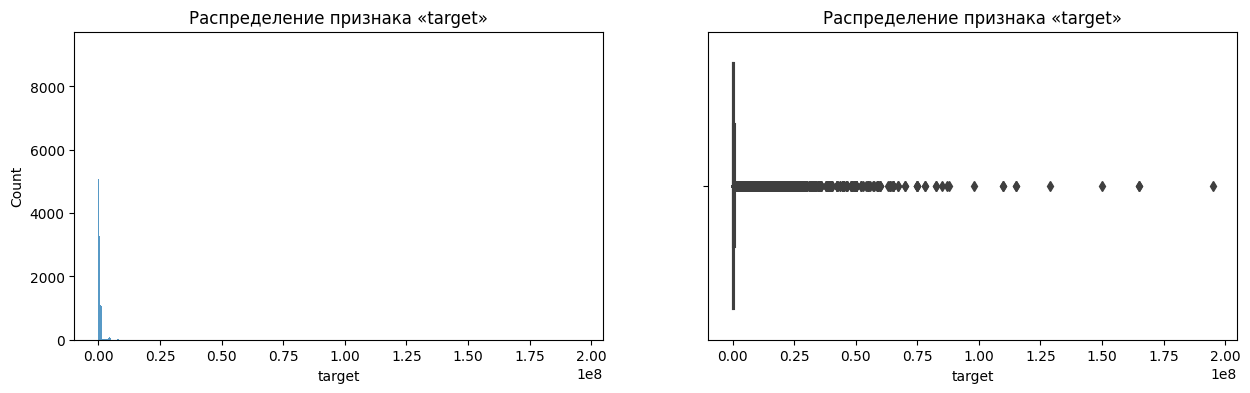

In [351]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data_new, x='target', ax=axes[0]);
histplot.set_title('Распределение признака «target»');
# histplot.axvline(data_new['target'].mean(), color='red', lw=2)

boxplot = sns.boxplot(data=data_new, x='target', ax=axes[1]);
boxplot.set_title('Распределение признака «target»');

Посмотрим на распределение нашего целевого признака в логарифмическом масштабе

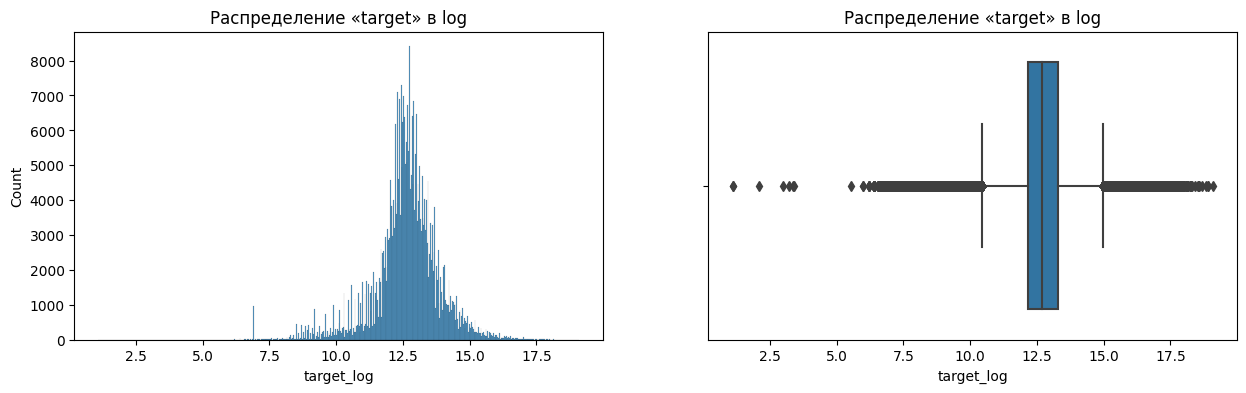

In [352]:
data_new['target_log'] = np.log(data_new['target'])

# посмотрим на графики
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=data_new, x='target_log', ax=axes[0]);
histplot.set_title('Распределение «target» в log');
boxplot = sns.boxplot(data=data_new, x='target_log', ax=axes[1]);
boxplot.set_title('Распределение «target» в log');

Проведем проверку на нормальность при помощи графиков квантилей QQ

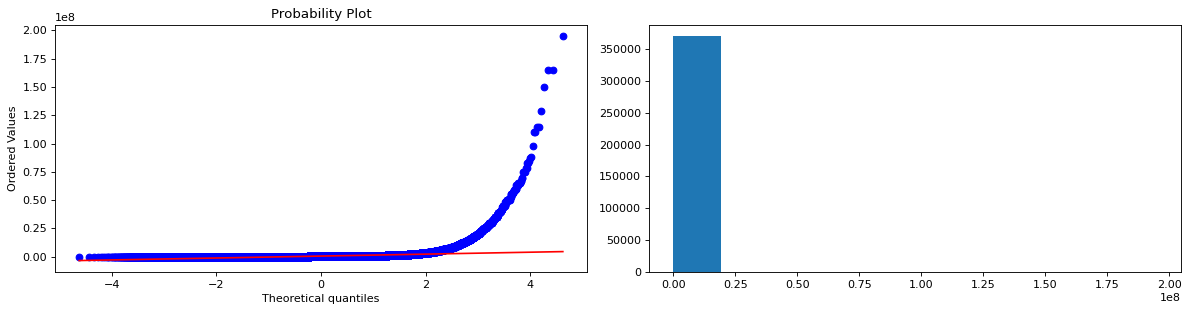

In [353]:
plt.figure(figsize=(15, 4), dpi=80)
plt.subplot(1, 2, 1)
stats.probplot(data_new['target'], plot=plt)

plt.subplot(1, 2, 2)
plt.hist(data_new['target'])

plt.tight_layout()
plt.show()

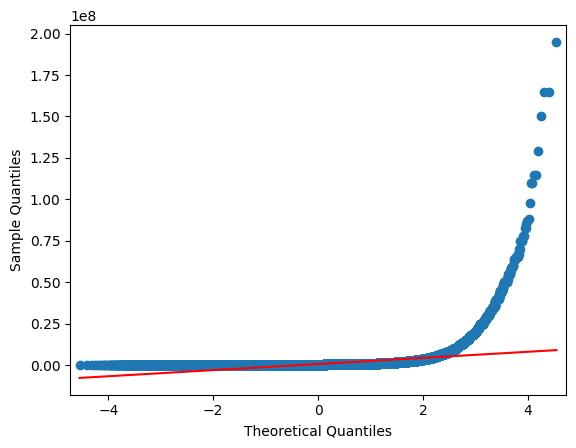

In [354]:
fig = sm.qqplot(data_new['target'], line='s')
plt.show()

видим, что этот набор данных не соответствует нормальному распределению в районе правого хвоста.  
То есть по графическим тестам мы можем сказать, что данные не имеют нормальной тенденции.

Хотя график QQ не является формальным статистическим тестом, он предлагает простой способ визуально проверить, нормально ли распределен набор данных.

In [355]:
stats.shapiro(data_new['target'])

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.21431779861450195, pvalue=0.0)

Из вывода мы видим, что статистика теста равна 0.2143 , а соответствующее значение pvalue=0.0 .

Поскольку p-значение меньше 0,05, мы отвергаем нулевую гипотезу. У нас есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.

Но есть предупреждение, что размер выборки должен до 5000, чтобы функция shapiro.test() работала корректно.

Тест Колмогорова-Смирнова используется для проверки того, происходит ли выборка из определенного распределения.

Выполним тест Колмогорова-Смирнова для наших данных, чтобы определить, являются ли они результатом нормального распределения:

In [356]:
stats.kstest(data_new['target'], 'norm')

KstestResult(statistic=0.9999946027633845, pvalue=0.0, statistic_location=8, statistic_sign=-1)

Видим, что статистика теста равна 0.99999 , а соответствующее значение pvalue=0.0. Поскольку p-значение меньше 0,05, мы отвергаем нулевую гипотезу. У нас есть достаточно доказательств, чтобы сказать, что данные выборки не имеют нормального распределения.

Проверим является ли распределение признака в логарифмическом масштабе нормальным?

Проверьте свою гипотезу с помощью теста Д’Агостино-Пирсона (scipy.stats.normaltest) при уровне значимости $\alpha=0.05$.

In [357]:
_, p = stats.normaltest(data_new.target_log)
#normaltest возвращает двустороннюю вероятность для проверки гипотезы поэтому уровень значимости делим на 2
print('p=%.2f' % p)

if p > 0.05/2:
    print('Тест на нормальность данных пройден успешно!')
else:
    print('Тест на нормальность данных НЕ пройден!')

p=0.00
Тест на нормальность данных НЕ пройден!


In [358]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370560 entries, 0 to 370559
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    370560 non-null  int64  
 1   status        370560 non-null  object 
 2   propertyType  370436 non-null  object 
 3   baths         370560 non-null  object 
 4   city          370560 non-null  object 
 5   schools       370560 non-null  object 
 6   sqft          370560 non-null  int64  
 7   zipcode       370560 non-null  object 
 8   state         370560 non-null  object 
 9   target        370560 non-null  int64  
 10  Pool          370560 non-null  bool   
 11  Year built    370560 non-null  object 
 12  r_sch_mean    370560 non-null  float64
 13  dist_sch_min  370560 non-null  float64
 14  target_log    370560 non-null  float64
dtypes: bool(1), float64(3), int64(3), object(8)
memory usage: 39.9+ MB


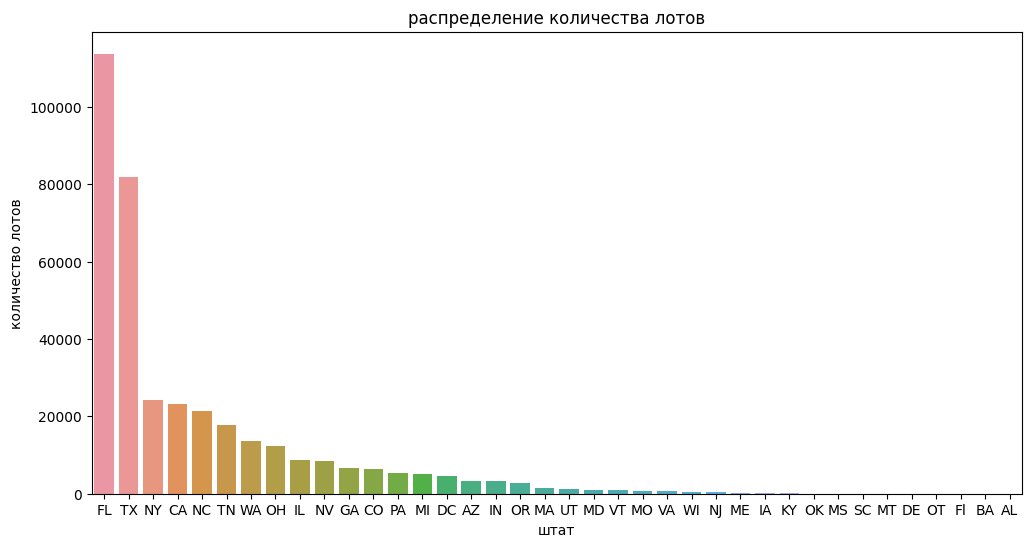

In [359]:
# Переведем признак state в категориальный тип
data_new.state = data_new.state.astype("category")
order=data_new.value_counts('state')

plt.rcParams['figure.figsize'] = (12,6)
fig, ax = plt.subplots()
bar = sns.barplot(data=data_new, x="state", y='target', estimator=len, order=order.index)
bar.set_title("распределение количества лотов")
bar.set_xlabel("штат")
bar.set_ylabel("количество лотов")
plt.show()

In [360]:
data_new = data_new.drop(['state'], axis=1)

In [361]:
# проверим не появились ли дубли
data_new.duplicated().sum()

0

In [362]:
data_new

,Unnamed: 0,status,propertyType,baths,city,schools,sqft,zipcode,target,Pool,Year built,r_sch_mean,dist_sch_min,target_log
0,0,active,singlefamily,3.5,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,418000,False,2019,5.2,2.70,12.943237
1,1,forsale,singlefamily,3,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947,99216,310000,False,2019,4.0,1.01,12.644328
2,2,forsale,singlefamily,2,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3000,90049,2895000,True,1961,6.7,1.19,14.878496
3,3,forsale,singlefamily,8,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",6457,75205,2395000,False,2006,9.0,0.10,14.688894
4,4,forsale,lot/land,unknown,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",-1,32908,5000,False,None,4.7,3.03,8.517193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370555,370555,undefined,singlefamily,6,Miami,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...",4017,33180,1249000,True,1990,5.0,1.10,14.037854
370556,370556,forsale,condo,3,Chicago,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...",2000,60657,674999,False,1924,4.3,0.40,13.422466
370557,370557,forsale,singlefamily,3,Jamaica,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...",1152,11434,528000,False,1950,4.5,0.48,13.176852
370558,370558,undefined,unknown,unknown,Houston,"[{'rating': ['NA', 'NA', 'NA'], 'data': {'Dist...",-1,77028,34500,False,None,-1.0,0.50,10.448715


In [363]:
test = data_new[data_new.drop(['city'], axis=1).duplicated(keep=False)]

In [364]:
data_new = data_new.drop(['city'], axis=1)

In [365]:
data_new = data_new.drop(['schools'], axis=1)

In [410]:
data_new = data_new.drop(['Unnamed: 0'], axis=1)

In [411]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370560 entries, 0 to 370559
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        370560 non-null  object 
 1   propertyType  370436 non-null  object 
 2   baths         370560 non-null  object 
 3   sqft          370560 non-null  int64  
 4   zipcode       370560 non-null  object 
 5   target        370560 non-null  int64  
 6   Pool          370560 non-null  bool   
 7   Year built    370560 non-null  object 
 8   r_sch_mean    370560 non-null  float64
 9   dist_sch_min  370560 non-null  float64
 10  target_log    370560 non-null  float64
dtypes: bool(1), float64(3), int64(2), object(5)
memory usage: 28.6+ MB


## 2. Отбор и преобразование признаков

In [412]:
data_new_2 = data_new.copy()

Закодируем категориальные признаки в наших данных

In [413]:
cols_to_code = ['status','propertyType','Year built','zipcode','baths']

In [414]:
#df_ohe = pd.get_dummies(data_new_2)

Данный энкодер не подходит, очень много признаков получается и недостаточно ОЗУ

Поэтому применим BinaryEncoder

In [415]:
enc = ce.BinaryEncoder(cols=cols_to_code)

In [416]:
df_be = enc.fit_transform(data_new_2.drop(['target', 'target_log'], axis=1))

In [417]:
df_be

,status_0,status_1,status_2,status_3,status_4,status_5,status_6,propertyType_0,propertyType_1,propertyType_2,...,Year built_0,Year built_1,Year built_2,Year built_3,Year built_4,Year built_5,Year built_6,Year built_7,r_sch_mean,dist_sch_min
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,5.2,2.70
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,4.0,1.01
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,6.7,1.19
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,9.0,0.10
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,4.7,3.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370555,0,0,0,0,0,1,1,0,0,0,...,0,1,0,0,1,1,0,0,5.0,1.10
370556,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,4.3,0.40
370557,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,1,1,1,4.5,0.48
370558,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,-1.0,0.50


In [418]:
df_be.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370560 entries, 0 to 370559
Data columns (total 49 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status_0        370560 non-null  int64  
 1   status_1        370560 non-null  int64  
 2   status_2        370560 non-null  int64  
 3   status_3        370560 non-null  int64  
 4   status_4        370560 non-null  int64  
 5   status_5        370560 non-null  int64  
 6   status_6        370560 non-null  int64  
 7   propertyType_0  370560 non-null  int64  
 8   propertyType_1  370560 non-null  int64  
 9   propertyType_2  370560 non-null  int64  
 10  propertyType_3  370560 non-null  int64  
 11  propertyType_4  370560 non-null  int64  
 12  propertyType_5  370560 non-null  int64  
 13  propertyType_6  370560 non-null  int64  
 14  propertyType_7  370560 non-null  int64  
 15  propertyType_8  370560 non-null  int64  
 16  propertyType_9  370560 non-null  int64  
 17  baths_0   

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log.

In [419]:
X = df_be
y = data_new_2['target']
y_log = data_new_2['target_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. Так как его распределение  ближе к нормальному.

Разобьём выборку на обучающую и валидационную в соотношении 70/30:

In [420]:
X_train, X_test, y_train_log, y_test_log = model_selection.train_test_split(X, y_log, test_size=0.3, random_state=42)

In [421]:
X_train.shape

(259392, 49)

слишком много признаков — оставим только те, которые сильнее всего связаны с целевой переменной

С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализую по обучающей выборке, используя параметр score_func = f_regression.

In [422]:
from sklearn.feature_selection import f_regression

select = feature_selection.SelectKBest(score_func = f_regression, k=25)
z = select.fit_transform(X_train,y_train_log)

In [423]:
filter_kb = select.get_support()

features = X_train.columns
print(features[filter_kb])

Index(['status_2', 'status_5', 'propertyType_2', 'propertyType_3',
       'propertyType_6', 'propertyType_7', 'propertyType_9', 'baths_0',
       'baths_1', 'baths_2', 'baths_3', 'baths_4', 'baths_5', 'baths_6',
       'sqft', 'zipcode_8', 'zipcode_12', 'Pool', 'Year built_2',
       'Year built_4', 'Year built_5', 'Year built_6', 'Year built_7',
       'r_sch_mean', 'dist_sch_min'],
      dtype='object')


In [424]:
# Масштабируем данные
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Решение задачи регрессии:

 воспользуемся моделью регрессии — классическая линейная регрессия по методу OLS (ordinary least squares).

In [425]:
reg = linear_model.LinearRegression()
reg.fit(X_train_scaled, y_train_log)
y_train_pred = reg.predict(X_train_scaled)
y_test_pred = reg.predict(X_test_scaled)

In [426]:
# исходя из формулы RMSLE нужно взять корень от MSE
print('Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_pred))))

Train RMSLE score: 1.05
Test RMSLE score: 1.05


Сгенерируем полиномиальные признаки второй степени с помощью PolynomialFeatures

In [427]:
poly = preprocessing.PolynomialFeatures(include_bias=False) # degree=2 по-умолчанию
poly.fit(X_train_scaled)

X_train_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для валидационной выборки
X_test_poly = poly.transform(X_test_scaled)

Построю модель полиномиальной регрессии второй степени на обучающей выборке

In [383]:
#Создаём объект класса LinearRegression
#reg_poly = linear_model.LinearRegression()
#Обучаем модель
#reg_poly.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
#y_train_predict_poly = reg_poly.predict(X_train_poly)
#Делаем предсказание для валидационной выборки
#y_test_predict_poly = reg_poly.predict(X_test_poly)

In [384]:
# метрики для полиноминальной регрессии
#print('Polynomial Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_poly))))
#print('Polynomial Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_poly))))

Метрика уменьшились для тренировочной выборки, но сильно увеличилась для тестовой. Поэтому построим модель полиномиальной регрессии второй степени с $L_2$-регуляризацией

In [428]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr = linear_model.Ridge(alpha=0.2) # alpha=1 по-умолчанию
#Обучаем модель
ridge_lr.fit(X_train_poly, y_train_log)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly_r = ridge_lr.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly_r = ridge_lr.predict(X_test_poly)

In [429]:
# метрики для полиноминальной регрессии
print('Polynomial-L2 Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_poly_r))))
print('Polynomial-L2 Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_poly_r))))

Polynomial-L2 Train RMSLE score: 0.88
Polynomial-L2 Test RMSLE score: 0.95


Попробуем модель дерева решений

In [430]:
dtr = tree.DecisionTreeRegressor()
dtr.fit(X_train_scaled, y_train_log)

y_train_predict_dtr = dtr.predict(X_train_scaled)
y_test_predict_dtr = dtr.predict(X_test_scaled)

In [431]:
# метрики для DecisionTreeRegressor
print('DecisionTreeRegressor Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_dtr))))
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_dtr))))

DecisionTreeRegressor Train RMSLE score: 0.16
DecisionTreeRegressor Test RMSLE score: 0.92


Явно видем признак переобучения модели!

Попробуем с глубиной дерева решений в диапазоне от 7 до 20:

In [432]:
# Задам словарь гиперпараметров для GridSearchCV
param_grid_DTR = {
              'max_depth': list(np.arange(6,21)) # максимальная глубина дерева
              }

In [433]:
#Создаем объект класса
grid_search_DTR = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeRegressor(),
    param_grid=param_grid_DTR,
    n_jobs = -1,
    scoring='neg_mean_squared_error')

In [434]:
# Запускаем подбор гиперпараметров
grid_search_DTR.fit(X_train_scaled, y_train_log)

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                       17, 18, 19, 20]},
             scoring='neg_mean_squared_error')

In [435]:
# посмотрим наилучшую найденную комбинацию гиперпараметров
grid_search_DTR.best_params_

{'max_depth': 13}

In [436]:
grid_search_DTR.best_score_

-0.6554705251071353

In [437]:
_MSLE = grid_search_DTR.score(X_test_scaled, y_test_log)
_MSLE

-0.64141774235349

In [438]:
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(-_MSLE)))

DecisionTreeRegressor Test RMSLE score: 0.80


Посмотрим на графики, как менялись метрики в зависимости от глубины дерева

In [439]:
RMSLE_tr=[]
RMSLE_test=[]
for n in np.arange(6,21):
    dtr2 = tree.DecisionTreeRegressor(max_depth=n)
    dtr2.fit(X_train_scaled, y_train_log)
    y_train_predict_dtr2 = dtr2.predict(X_train_scaled)
    y_test_predict_dtr2 = dtr2.predict(X_test_scaled)
    mse_gs_train = metrics.mean_squared_error(y_train_predict_dtr2, y_train_log)
    mse_gs_test = metrics.mean_squared_error(y_test_predict_dtr2, y_test_log)
    RMSLE_tr.append(round(mse_gs_train**0.5, 2))
    RMSLE_test.append(mse_gs_test**0.5) #округление лучше не использовать, график тогда ломаный получается

In [440]:
# создадим фрейм
rmsle = pd.DataFrame({"depth":np.arange(6,21),"train":RMSLE_tr,"test":RMSLE_test})

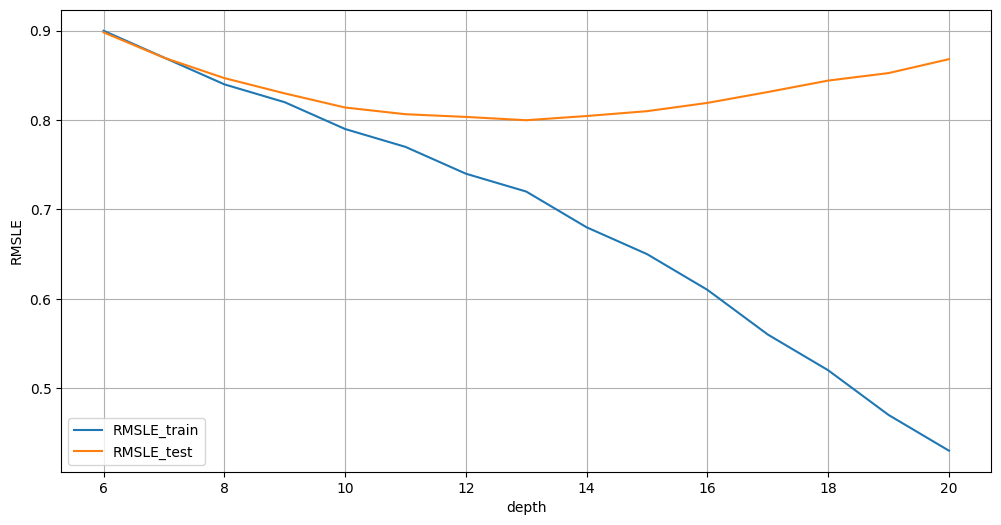

In [441]:
fig, axs = plt.subplots()
line = sns.lineplot(data=rmsle,x="depth",y="train",label="RMSLE_train")
line2 = sns.lineplot(data=rmsle,x="depth",y="test",label="RMSLE_test")
line.set_ylabel("RMSLE")
axs.grid()

## 4. Решение задачи регрессии: ансамблевые методы

Построим модель случайного леса с найденной нами ранее наилучшим параметром глубины. Парметр criterion = 'squared_error' установлен в модели по-умолчанию

In [442]:
rfr = ensemble.RandomForestRegressor(max_depth=12,
                                  n_estimators=200,
                                  min_samples_split = 20,
                                  random_state=42,
                                    n_jobs = -1)

rfr.fit(X_train_scaled, y_train_log)

y_train_predict_rfr = rfr.predict(X_train_scaled)
y_test_predict_rfr = rfr.predict(X_test_scaled)

# метрики
print('DecisionTreeRegressor Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_rfr))))
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_rfr))))

DecisionTreeRegressor Train RMSLE score: 0.72
DecisionTreeRegressor Test RMSLE score: 0.76


Благодаря параллельному обучению нескольких деревьев модель случайного леса дала нам небольшой прирост качества по сравнению с обычным деревом решений.

Посмотрим, что будет при последовательном ансамблировании ↓

Построю модель градиентного бустинга над деревьями решений (GradientBoostingRegressor)

In [443]:
gbr = ensemble.GradientBoostingRegressor(learning_rate = 0.5,
                                         max_depth=6,
                                         n_estimators=100, #количество деревьев по-умолчанию
                                         min_samples_split = 30,
                                         random_state=42 #генератор случайных чисел
                                         )
gbr.fit(X_train_scaled, y_train_log)

y_train_predict_gbr = gbr.predict(X_train_scaled)
y_test_predict_gbr = gbr.predict(X_test_scaled)

# метрики
print('DecisionTreeRegressor Train RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_predict_gbr))))
print('DecisionTreeRegressor Test RMSLE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test_log, y_test_predict_gbr))))

DecisionTreeRegressor Train RMSLE score: 0.66
DecisionTreeRegressor Test RMSLE score: 0.69


Метрики улучшились

Посмотрим на важность факторов для наилучшей ансамблевой модели.

<Axes: >

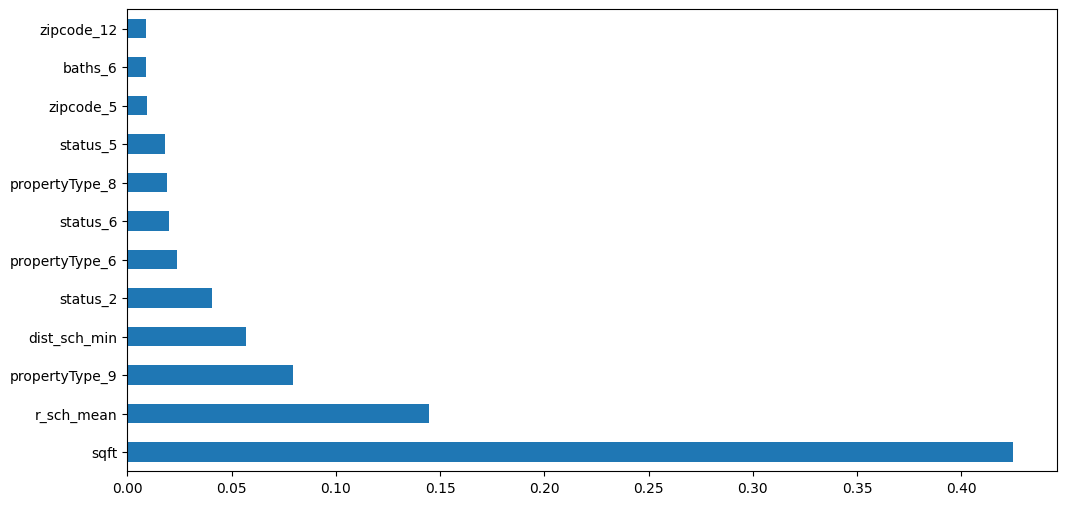

In [444]:
# есть возможность вывести самые важные признаки для модели через атрибут feature_importances_
plt.rcParams['figure.figsize'] = (12,6)
feat_importances = pd.Series(gbr.feature_importances_, index=X_train.columns)
feat_importances.nlargest(12).plot(kind='barh')

Поскольку категориальные признаки кодировал бинарным кодированием, то не представляется возможным оценить важность этих признаков. Но а вот иерархию важности числовых признаков мы можем наблюдать. Видим, что больше всего на цену влияет параметр полезной площади, что собственно логично. Далее по важности идут параметры: средний рейтинг ближайших школ и расстояние до ближайшей школы.

Несмотря на все преимущества, у метрики RMSLE есть один недостаток — она не является интерпретируемой. Поэтому для лучшей из построенных моделей рассчитаю медианную абсолютную ошибку (MeAE, в sklearn — функция median_absolute_error)

In [445]:
y_test = np.exp(y_test_log)
y65_test_predict = np.exp(y_test_predict_gbr)

mae_test = metrics.median_absolute_error(y_test, y65_test_predict)
mae_test

93388.77486833546

## 5. построение прогноза

Перед созданием прогноза для новых объектов необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой. Но! Считаю это не совсем логичным. Поскольку при анализе начальных данных многие признаки были признаны не пригодными для будущей модели и отброшены, то логичнее построить сервис предсказания, запрашивая только те признаки, которые явно участвуют в модели предсказания. То есть запрос входных данных для новых объектов перед подачей на вход модели должен иметь формат нашего очищенного фрейма df_v16.

In [446]:
data_new_2.head()

,status,propertyType,baths,sqft,zipcode,target,Pool,Year built,r_sch_mean,dist_sch_min,target_log
0,active,singlefamily,3.5,2900,28387,418000,False,2019,5.2,2.70,12.943237
1,forsale,singlefamily,3,1947,99216,310000,False,2019,4.0,1.01,12.644328
2,forsale,singlefamily,2,3000,90049,2895000,True,1961,6.7,1.19,14.878496
3,forsale,singlefamily,8,6457,75205,2395000,False,2006,9.0,0.10,14.688894
4,forsale,lot/land,unknown,-1,32908,5000,False,None,4.7,3.03,8.517193


In [447]:
data_new_2.columns

Index(['status', 'propertyType', 'baths', 'sqft', 'zipcode', 'target', 'Pool',
       'Year built', 'r_sch_mean', 'dist_sch_min', 'target_log'],
      dtype='object')

In [448]:
# Структура должна быть такая
data_new_2.drop(['target','target_log'],axis=1).loc[1].values

array(['forsale', 'singlefamily', '3', 1947, '99216', False, '2019', 4.0,
       1.01], dtype=object)

In [449]:
cols = data_new_2.drop(['target','target_log'],axis=1).columns

In [450]:
# Создадим первый запрос
request = [['active', 'single family', '3.5', 2900, '28387', True, '2019', 5.2, 2.7]]

Далее проводим последовательно те-же самые манипуляции, что и над тестовой выборкой:
 - BinaryEncoder,
 - StandardScaler,
 - непосредственно само предсказание с помощью GradientBoostingRegressor

In [451]:
req = pd.DataFrame(request, columns=cols)

In [452]:
req

,status,propertyType,baths,sqft,zipcode,Pool,Year built,r_sch_mean,dist_sch_min
0,active,single family,3.5,2900,28387,True,2019,5.2,2.7


In [453]:
# Первый шаг - BinaryEncoder
req_be = enc.transform(req)

In [454]:
req_be

,status_0,status_1,status_2,status_3,status_4,status_5,status_6,propertyType_0,propertyType_1,propertyType_2,...,Year built_0,Year built_1,Year built_2,Year built_3,Year built_4,Year built_5,Year built_6,Year built_7,r_sch_mean,dist_sch_min
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,5.2,2.7


In [455]:
# Второй шаг - StandardScaler
req_ss = scaler.transform(req_be)

In [456]:
req_ss

array([[-0.01317242, -0.04012722, -0.15943286, -0.15840012, -0.23345029,
        -1.41800026,  1.19846351, -0.02096861, -0.03784595, -0.06258364,
        -0.09250861, -0.17987958, -0.26166409, -0.59307608, -0.49361007,
        -0.61772911, -2.52819505, -0.02012354, -0.06975423, -0.2302654 ,
        -0.40948141, -0.89071613, -1.25910154,  0.57653712,  0.01393   ,
        -0.04228634, -0.3673032 , -0.65754772, -0.82421214, -0.88249059,
        -0.94049315, -0.97476621, -0.98729694, -1.01490724, -0.96894663,
        -0.99601399, -1.04220977,  0.99482434,  2.88037114, -0.09700264,
        -0.55062623, -0.763418  , -0.66717995, -0.76611499, -1.04639658,
        -0.81799389,  1.01463333,  0.1843433 ,  0.33341132]])

In [457]:
# Третий шаг - предсказание
req_predict_log = rfr.predict(req_ss)

In [458]:
req_predict_log

array([13.16190998])

In [459]:
# перевод из логарифмической шкалы в изначальную
req_predict = np.exp(req_predict_log)

In [460]:
req_predict

array([520169.49200539])

Можно все это обернуть в функцию для удобства

In [461]:
def final_predict(rec_list):
    req_f = pd.DataFrame([rec_list], columns=cols)
    req_be_f = enc.transform(req_f)
    req_ss_f = scaler.transform(req_be_f)
    req_predict_log_f = rfr.predict(req_ss_f)
    return round(np.exp(req_predict_log_f[0]))

Попробую второй запрос прогнать через данную функцию

In [462]:
request2 = ['forsale', 'single family', '3', 1947, '99216', True, '2019', 4.0, 1.01]

In [463]:
final_predict(request2)

219242

In [464]:
request3 = ['foreclosure', 'condo','3', 1780, '46250', False, '1989',  3.7, 1.71]
final_predict(request3)

213392

## 6. Подготовка модели к продакшену

Теперь, когда модель отработана и проверена, можно готовить ее к запуску в production

Наши подготовленные данные находятся в переменной data_new_2

In [465]:
data_new_2

,status,propertyType,baths,sqft,zipcode,target,Pool,Year built,r_sch_mean,dist_sch_min,target_log
0,active,singlefamily,3.5,2900,28387,418000,False,2019,5.2,2.70,12.943237
1,forsale,singlefamily,3,1947,99216,310000,False,2019,4.0,1.01,12.644328
2,forsale,singlefamily,2,3000,90049,2895000,True,1961,6.7,1.19,14.878496
3,forsale,singlefamily,8,6457,75205,2395000,False,2006,9.0,0.10,14.688894
4,forsale,lot/land,unknown,-1,32908,5000,False,None,4.7,3.03,8.517193
...,...,...,...,...,...,...,...,...,...,...,...
370555,undefined,singlefamily,6,4017,33180,1249000,True,1990,5.0,1.10,14.037854
370556,forsale,condo,3,2000,60657,674999,False,1924,4.3,0.40,13.422466
370557,forsale,singlefamily,3,1152,11434,528000,False,1950,4.5,0.48,13.176852
370558,undefined,unknown,unknown,-1,77028,34500,False,None,-1.0,0.50,10.448715


In [466]:
# Создаём пайплайн, который включает все наши шаги по подготовке данных и обучению модели
pipe = Pipeline([
  ('BinaryEncoder', enc),
  ('StandardScaler', scaler),
  ('GradientBoostingRegressor', gbr)
  ])

In [469]:
# Входными данными для пайплайна будут
X_p = data_new_2.drop(['target', 'target_log'], axis=1)
y_p = data_new_2['target_log']

In [470]:
# Обучаем пайплайн
pipe.fit(X_p, y_p)

Pipeline(steps=[('BinaryEncoder',
                 BinaryEncoder(cols=['status', 'propertyType', 'Year built',
                                     'zipcode', 'baths'],
                               mapping=[{'col': 'status',
                                         'mapping':      status_0  status_1  status_2  status_3  status_4  status_5  status_6
 1          0         0         0         0         0         0         1
 2          0         0         0         0         0         1         0
 3          0         0         0         0         0         1         1
 4          0         0         0         0         1         0         0
 5          0         0         0         0         1         0         1
..        ...       ...       ...       ...       ...       ...       ...
 92         1         0         1         1         1         0         0
 93         1         0         1         1         1         0         1
 94         1         0         1         1         1         1         0
-1          0         0         0         0         0         0         0
-2          0         0         0         0         0         0         0

[96 rows x 7 columns]},
                                        {'col': 'propertyType',
                                         'm...
                                         'mapping':       baths_0  baths_1  baths_2  baths_3  baths_4  baths_5  baths_6
 1          0        0        0        0        0        0        1
 2          0        0        0        0        0        1        0
 3          0        0        0        0        0        1        1
 4          0        0        0        0        1        0        0
 5          0        0        0        0        1        0        1
...       ...      ...      ...      ...      ...      ...      ...
 102        1        1        0        0        1        1        0
 103        1        1        0        0        1        1        1
 104        1        1        0        1        0        0        0
-1          0        0        0        0        0        0        0
-2          0        0        0        0        0        0        0

[106 rows x 7 columns]}])),
                ('StandardScaler', StandardScaler()),
                ('GradientBoostingRegressor',
                 GradientBoostingRegressor(learning_rate=0.5, max_depth=6,
                                           min_samples_split=30,
                                           random_state=42))])

Сериализуем нашу обученную модель.

In [485]:
# Сериализуем и записываем результат в файл
with open('/content/drive/MyDrive/data/diplom_DS.pkl', 'wb') as output:
    pickle.dump(pipe, output)

## Заключение

За время работы над этим проектом, мне удалось:

Преобразовать данные для того, чтобы ими можно было пользоваться
Создать массу новых признаков, тем самым увеличив информативность данных
Очистить данные от пропусков, выбросов и неинформативных признаков
Провести качественный анализ данных с применением математической статистики
Отобрать из данных самые сильные признаки.
Перебрать много моделей и на основе нескольких метрик выбрать лучшую
Сохранить модель в формат pickle и применить ее в продакшне.
